In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
import math
from datetime import timedelta
from fbprophet import Prophet
from pmdarima.arima import auto_arima
from dateutil.relativedelta import *
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.preprocessing import FourierFeaturizer
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm
from scipy.stats import boxcox
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [2]:
import os
os.getcwd()
#os.chdir('/Users/....')


'C:\\Users\\Jean-Philippe\\Documents'

In [3]:
#Change your file dorectory
os.chdir('C:\\Users\\Jean-Philippe\\Desktop\\python_files\\week5')

In [4]:
#load sales data in dfSales and show head
dfSales = pd.read_csv('sales_train.csv')


In [5]:
#format date string into Python format date using datetime import library
#this can take some time like 30sec
# good read on lambda https://www.python-course.eu/python3_lambda.php
dfSales.date=dfSales.date.apply(lambda df1:datetime.strptime(df1, '%d.%m.%Y'))#apply lambda function over all the date column
dfSales.head(5)
#print(dfSales.info())

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0

In [6]:
#describe() to see what we got
dfSales.describe()



date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03

In [7]:
print("We have 2.9 millions transaction mean qty is 1.24 std is 2.6 ")

We have 2.9 millions transaction mean qty is 1.24 std is 2.6 


In [8]:
#load item_categories data in dfItemCat and show the number of categories we have
dfItemCat = pd.read_csv('item_categories.csv')
c=dfItemCat.count()
print("We Got "+ str(c))



We Got item_category_name    84
item_category_id      84
dtype: int64


In [9]:
dfItemCat.head(5)

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [10]:
print("Category are in Russian it may be useful to translate to English to create a super category like Video Game.")
print("Some Category come and go so it can be good to fiend for the new category with less data some like category.")
print("For example, the second month of sales of the new XBOX One will be like the second month of sale for the XBOX 360.")

Category are in Russian it may be useful to translate to English to create a super category like Video Game.
Some Category come and go so it can be good to fiend for the new category with less data some like category.
For example, the second month of sales of the new XBOX One will be like the second month of sale for the XBOX 360.


In [11]:
#load items data in dfItems and show the number of items we have
dfItems = pd.read_csv('items.csv')
c=dfItems.count()
print("We Got "+ str(c))

We Got item_name           22170
item_id             22170
item_category_id    22170
dtype: int64


In [12]:
dfItems.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [13]:
item_count_by_cat=dfItems.groupby(["item_category_id"]).agg({"item_id":"count"})
item_count_by_cat.head(5)

item_id
item_category_id         
0                       4
1                       2
2                      75
3                      34
4                      15

In [14]:
#load shop data in dfShops and show the number of shop we have
dfShops = pd.read_csv('shops.csv')
c=dfShops.count()
print("We Got "+ str(c))

We Got shop_name    60
shop_id      60
dtype: int64


In [15]:
#load sample_submission data in dfSolutionex and show the number of forcast we have to do
dfSolutionex = pd.read_csv('sample_submission.csv')
c=dfSolutionex.count()
print(str(c))


ID                214200
item_cnt_month    214200
dtype: int64


In [16]:
print("We got 214200 forecast to do")

We got 214200 forecast to do


In [17]:
#load test data in dfTest and show the number of forcast we have to do and on what
dfTest = pd.read_csv('test.csv')
dfTest.count()


ID         214200
shop_id    214200
item_id    214200
dtype: int64

In [18]:
ShoptoForc = dfTest["shop_id"].nunique()
print("We have to forecast on "+ str(ShoptoForc)+" different stores on that 60 list ")

We have to forecast on 42 different stores on that 60 list 


In [19]:
dfTest = pd.read_csv('test.csv')
ItemtoForc = dfTest["item_id"].nunique()
print("We have to forecast on "+str(ItemtoForc)+" different items on that list of 22170")

We have to forecast on 5100 different items on that list of 22170


In [20]:
###create dfItemListToForc the list of Item to forecast 
dfItemtoForc = dfTest.groupby(["item_id"]).nunique()
dfItemListToForc=pd.DataFrame()
dfItemListToForc=pd.DataFrame({"item_id" : dfItemtoForc.index})
#dfItemListToForc.head()
dfItemListToForc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Data columns (total 1 columns):
item_id    5100 non-null int64
dtypes: int64(1)
memory usage: 39.9 KB


In [21]:
###Merge item category with our sale data to get the category we af to forecast
dfTestCat = pd.merge(dfTest, dfItems , on='item_id')
CattoForc = dfTestCat["item_category_id"].nunique()
print("We have to forecast on "+str(CattoForc)+" different category on that list of 84")


We have to forecast on 62 different category on that list of 84


In [22]:
###create dfItemCatListToForc the list of Item to forecast
dfItemCattoForc = dfTestCat.groupby(["item_category_id"]).nunique()
dfItemCatListToForc=pd.DataFrame()
dfItemCatListToForc=pd.DataFrame({"item_category_id" : dfItemCattoForc.index})
dfItemCatListToForc.head()
#dfItemCatListToForc.info()

item_category_id
0                 0
1                 2
2                 3
3                 5
4                 6

In [23]:
###Merge item category with our sale data
dfSales = pd.merge(dfSales, dfItems , on='item_id')
dfSales.head(5)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154       999.0           1.0   
1 2013-01-23               0       24    22154       999.0           1.0   
2 2013-01-20               0       27    22154       999.0           1.0   
3 2013-01-02               0       25    22154       999.0           1.0   
4 2013-01-03               0       25    22154       999.0           1.0   

           item_name  item_category_id  
0  ЯВЛЕНИЕ 2012 (BD)                37  
1  ЯВЛЕНИЕ 2012 (BD)                37  
2  ЯВЛЕНИЕ 2012 (BD)                37  
3  ЯВЛЕНИЕ 2012 (BD)                37  
4  ЯВЛЕНИЕ 2012 (BD)                37

In [24]:
#### get month of the year and merge it with sale data with category 
### we create to array one with date_block_month and one with the related month of the year
dfmonth = pd.DataFrame({'date_block_num': ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18'
                                           ,'19','20','21','22','23','24','25','26','27','28','29','30','31','32','33'],
                        'month': ['1','2','3','4','5','6','7','8','9','10','11','12','1','2','3','4','5','6','7','8','9','10'
                                  ,'11','12','1','2','3','4','5','6','7','8','9','10']})
dfmonth=dfmonth.astype(int)
dfSales = pd.merge(dfSales, dfmonth , on='date_block_num')
dfSales.head(5)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154       999.0           1.0   
1 2013-01-23               0       24    22154       999.0           1.0   
2 2013-01-20               0       27    22154       999.0           1.0   
3 2013-01-02               0       25    22154       999.0           1.0   
4 2013-01-03               0       25    22154       999.0           1.0   

           item_name  item_category_id  month  
0  ЯВЛЕНИЕ 2012 (BD)                37      1  
1  ЯВЛЕНИЕ 2012 (BD)                37      1  
2  ЯВЛЕНИЕ 2012 (BD)                37      1  
3  ЯВЛЕНИЕ 2012 (BD)                37      1  
4  ЯВЛЕНИЕ 2012 (BD)                37      1

In [25]:
### Group by item sum by date_block_num to get monthly sales by item and chart that.
### good read on pivot table https://pbpython.com/pandas-pivot-table-explained.html
sales_by_item_id = dfSales.pivot_table(index=['item_id'],values=['item_cnt_day'],columns='date_block_num',
                                       aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'
sales_by_item_id.head(5)


item_id  0  1  2  3  4  5  6  7  8  ...  24  25  26  27  28  29  30  31  \
0        0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
1        1  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
2        2  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
3        3  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
4        4  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   

   32  33  
0   0   0  
1   0   0  
2   0   0  
3   0   0  
4   0   0  

[5 rows x 35 columns]

In [26]:
#creating a total sale dataframe column and getting product with no historic sale and the top 10 historic best seller
Total_sales_by_item = pd.DataFrame()
col_list= list(sales_by_item_id)
col_list.remove("item_id")
Total_sales_by_item['total']= sales_by_item_id[col_list].sum(axis=1)
Total_sales_by_item["item_id"]=sales_by_item_id["item_id"]
Total_zero_item = Total_sales_by_item.loc[lambda df1: df1.total == 0,:] 
Total_sales_by_item=Total_sales_by_item.sort_values(by="total", ascending=False)

print("\n Never Sale \n")
print(Total_zero_item)
print("\n TOP 10 \n")
print(Total_sales_by_item.head(10))


 Never Sale 

       total  item_id
4504       0     4591
7401       0     7547
8350       0     8515
13226      0    13477

 TOP 10 

        total  item_id
20602  187642    20949
2749    17245     2808
3654    16642     3732
17418   15830    17717
5717    14515     5822
3656    11688     3734
6543    10289     6675
3653    10099     3731
1814    10032     1855
16493    9227    16787


In [27]:
print(dfItems.loc[lambda df1: df1.item_id == 7807,:])

                                              item_name  item_id  \
7807  Watch_Dogs. Специальное издание [PS4, русская ...     7807   

      item_category_id  
7807                20  


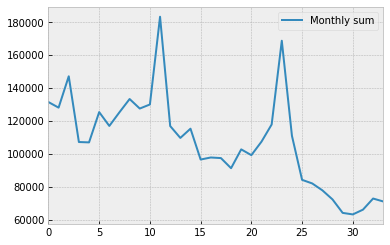

In [28]:
#Plot sales by month block
sales_by_item_id.sum()[1:].plot(legend=True, label="Monthly sum")


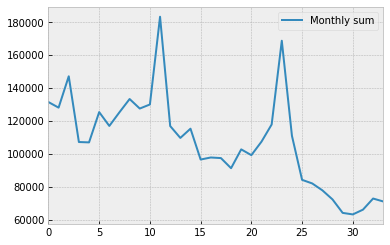

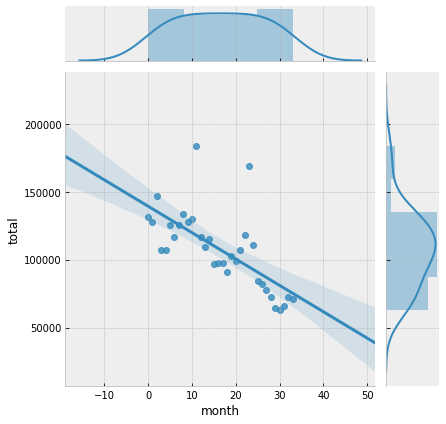

In [29]:
#Plot sales by month block to see the down trend
sales_by_item_id.sum()[1:].plot(legend=True, label="Monthly sum")

ts= pd.DataFrame()
ts['total']=sales_by_item_id.sum()[1:]
ts['month']=ts.index.astype(float)
g = sns.jointplot("month", "total", data=ts, kind="reg")

We have a strong declining monthly trend near -25% per year so we will have to remove that trend from the data for stationnarity for regression and consider the viriable date_block_num into our model

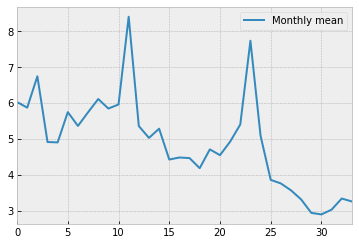

In [30]:
sales_by_item_id.mean()[1:].plot(legend=True, label="Monthly mean")

Same trend for the monthly mean by item

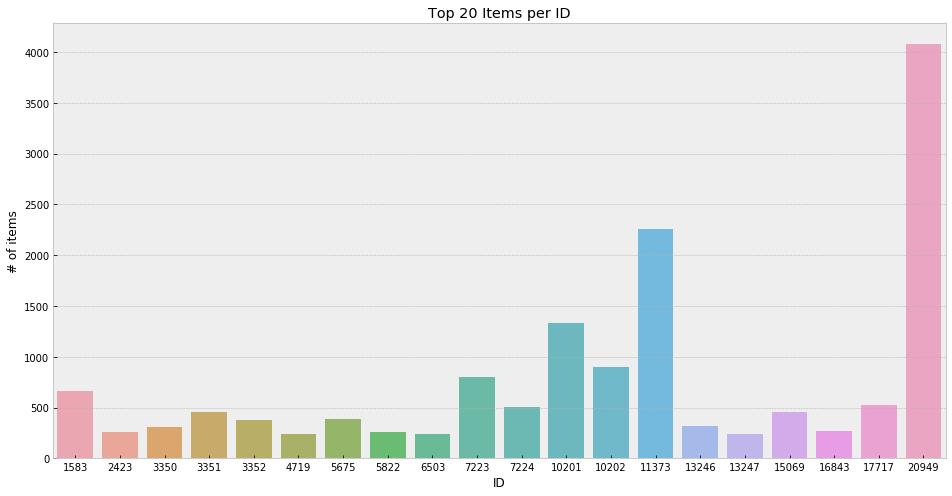

In [31]:
###top 20 selling item in October 2015
October_sales_by_item_id = sales_by_item_id['33']
x=October_sales_by_item_id.to_frame()
x["item_id"]=sales_by_item_id["item_id"]
x=x.rename(columns={ "33":"item_cnt" })
x=x.sort_values(by="item_cnt", ascending=False)
x20=x.head(20)
plt.figure(figsize=(16,8))
ax= sns.barplot(x20.item_id, x20.item_cnt, alpha=0.8)
plt.title("Top 20 Items per ID")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('ID', fontsize=12)
plt.show()

In [32]:
### merge Zeroitem (item with zero sale in October) and ItemListToForc to see if we have product with 0 unit sale in October to forcast in November and product 
### with no historic sales 
ZeroItem = x.loc[lambda df1: df1.item_cnt==0]
ZeroItemToForc = pd.merge(ZeroItem,dfItemListToForc, on="item_id", how='inner')
NewItemToForc= pd.merge(Total_zero_item , ZeroItemToForc, on="item_id", how='inner' ) 
#print(ZeroItemToForc)
print(ZeroItemToForc.count())
print("From the 5100 item to forcast 746 has no sales in October\n")
print(NewItemToForc.count())
print("we got no item with zero historic sale to forcast so those 746 are probably dead item\n")


item_cnt    746
item_id     746
dtype: int64
From the 5100 item to forcast 746 has no sales in October

total       0
item_id     0
item_cnt    0
dtype: int64
we got no item with zero historic sale to forcast so those 746 are probably dead item



In [33]:
### pivot_table Group by category sum by date_block_num to get monthly sales by category and chart that.
sales_by_category_id = dfSales.pivot_table(index=['item_category_id'],values=['item_cnt_day'],columns='date_block_num',
                                       aggfunc=np.sum, fill_value=0).reset_index()
sales_by_category_id.columns = sales_by_category_id.columns.droplevel().map(str)
sales_by_category_id = sales_by_category_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_category_id.columns.values[0] = 'item_category_id'
sales_by_category_id.head(5)

item_category_id     0     1     2    3    4    5    6    7    8  ...  \
0                 0     1     1     0    1    0    0    0    0    0  ...   
1                 1     1     1     0    0    0    0    0    0    0  ...   
2                 2  1390  1190  1025  646  596  667  618  674  792  ...   
3                 3   440   302   293  202  146  150  233  300  383  ...   
4                 4   251   220   226  160  175  176  179  140   86  ...   

     24   25   26   27   28   29   30   31    32    33  
0     0    0    0    0    0    0    0    0     0     0  
1     0    0    0    0    0    0    0    0     0     0  
2   370  307  229  170  146  104  114  132    89    82  
3  1398  834  773  746  667  559  603  975  1090  1059  
4    10    2    2    2    2    1    0    1     0     0  

[5 rows x 35 columns]

In [34]:
### Top category for October
October_sales_by_category_id = sales_by_category_id['33']
x=October_sales_by_category_id.to_frame()
x["item_category_id"]=sales_by_category_id["item_category_id"]
x=x.rename(columns={ "33":"item_cnt" })
x=x.sort_values(by="item_cnt", ascending=False)
print('top 10 category')
x.head(10)

top 10 category


item_cnt  item_category_id
40      7680                40
20      6596                20
55      5808                55
30      4150                30
71      4078                71
37      4061                37
47      3421                47
28      2857                28
9       2524                 9
19      2443                19

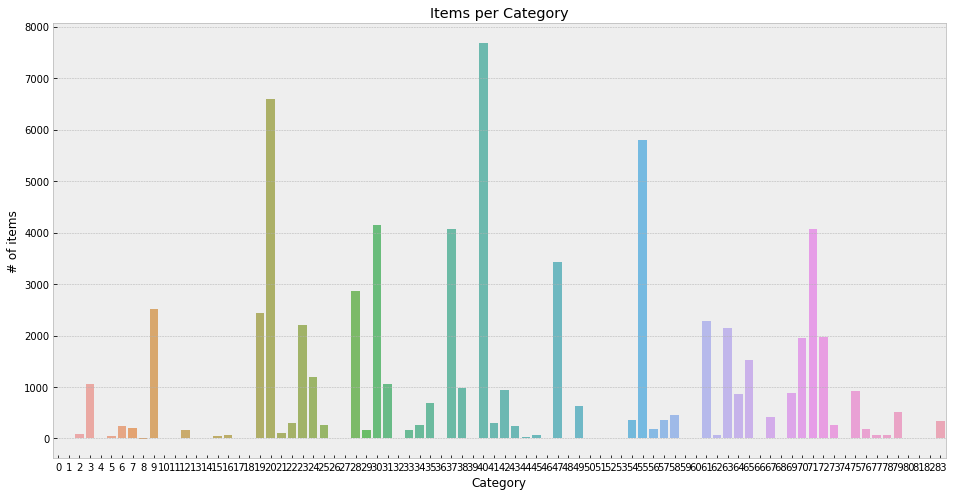

In [35]:
## histogram for category for October_sales_by_category_id
plt.figure(figsize=(16,8))
ax= sns.barplot(x.item_category_id, x.item_cnt, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [36]:
### merge ZeroCat and ItemCatListToForc to see if we have categery with 0 unit sale to forcast in November
ZeroCat = x.loc[lambda df1: df1.item_cnt==0]
#print(ZeroCat)
ZeroCatToForc = pd.merge(ZeroCat,dfItemCatListToForc, on="item_category_id", how='inner')
print(ZeroCatToForc)


   item_cnt  item_category_id
0         0                 0


look like we don't have category with 0 sales in October to forcast so no totaly new category

In [37]:
###Create a dataframe dfFirst2y to get only the first two full year to do stats per month for seasonlity
### sale Group by month of the year group by category
dfFirst2y=dfSales.loc[lambda df1: df1.date_block_num <= 23,:]
sales_by_month_cid = dfFirst2y.pivot_table(index=['item_category_id'],values=['item_cnt_day'],columns='month',
                                       aggfunc=np.sum, fill_value=0).reset_index()
sales_by_month_cid.columns = sales_by_month_cid.columns.droplevel().map(str)
sales_by_month_cid = sales_by_month_cid.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_month_cid.columns.values[0] = 'item_category_id'
sales_by_month_cid.head()

item_category_id     1     2     3     4     5     6     7     8     9  \
0                 0     1     1     0     1     0     0     0     0     0   
1                 1     1     1     0     0     0     0     0     0     0   
2                 2  2729  1932  1670  1154  1040  1154   969  1016  1147   
3                 3  1620  2211  1433   871   862  1005  1106  1482  1665   
4                 4   347   266   284   195   218   230   225   175   107   

     10    11    12  
0     0     0     0  
1     0     0     0  
2  1162  1116  2765  
3  1514  1871  5463  
4   116    92   132

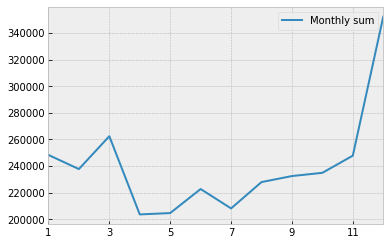

In [38]:
sales_by_month_cid.sum()[1:].plot(legend=True, label="Monthly sum")

Look like in november unit sales are around 5% higher than October for the last 2 year or around 10000 more unit.
We see some sesonality effect with a big peak in December

In [39]:
#Pivot table group by shop id and group by category id
sales_by_item_ids = dfSales.pivot_table(index=['item_category_id'],values=['item_cnt_day'],columns='shop_id',
                                       aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_ids.columns = sales_by_item_ids.columns.droplevel().map(str)
sales_by_item_ids = sales_by_item_ids.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_ids.columns.values[0] = 'item_id'
sales_by_item_ids.head(5)

item_id    0   1    2    3    4    5    6    7   8  ...   50   51   52  \
0        0    1   0    0    0    0    0    0    0   0  ...    0    0    0   
1        1    1   0    0    0    0    0    0    0   0  ...    0    0    0   
2        2  105  63  355  200  309  232  422  491  19  ...  733  231  250   
3        3   52  18  527  360  333  340  755  554   0  ...  773  247  376   
4        4   38  30   42   28  101   38   21   92   2  ...   92   56   55   

    53    54  55   56   57   58   59  
0    0     0   0    0    0    0    0  
1    0     0   0    0    0    0    0  
2  341   874   0  338  669  324  223  
3  460  1098   0  472  965  574  399  
4   68   103   0   46  149   80   52  

[5 rows x 61 columns]

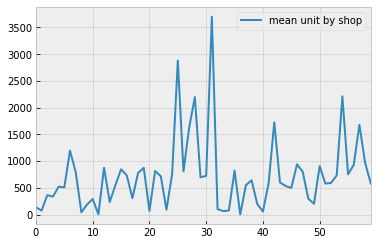

In [40]:
#mean unit by shop plot
sales_by_item_ids.mean()[1:].plot(legend=True, label="mean unit by shop")

Lot of variation by store some sales almot nothing some sales a lot more

# Next part is about more item specific variable that influance unit sale

In [41]:
#We create a data frame DFfirstsale with the aproximate realease date of an item
#this will be use to see the age effect on sale New product sale more than older one
#this will also be use to predict unit sale base on past unit sales for similar product at the same age
sales_by_item_id['total']=Total_sales_by_item['total']

n=sales_by_item_id['item_id'].count()
DFfirstsale=pd.DataFrame([[0, 0]], columns=['item_id','first_month']) 
for i in range(0,n):
    for j in range(0,34):
        j=str(j)
        if sales_by_item_id.loc[i].at[j]>0 and sales_by_item_id.loc[i].at['total']>1:
            #print([sales_by_item.loc[i].at['item_id'] , int(j)])
            df = pd.DataFrame([[sales_by_item_id.loc[i].at['item_id'] , int(j)]],columns=['item_id','first_month'])
            DFfirstsale=DFfirstsale.append(df)
            break

DFfirstsale.head(5)    

item_id  first_month
0        0            0
0        1           15
0        2           19
0        3           18
0        8           19

In [42]:
#Build a DF with the first 6 months of sale product that have more than 6 months of sales to help to predict new product 
dfnewitem= DFfirstsale.loc[lambda df1: df1.first_month>=30]
dfnewitemtoforc=pd.merge(dfItemListToForc,dfnewitem, on= 'item_id', how='inner')
dfolditem= DFfirstsale.loc[lambda df1: df1.first_month<28 ]
dfolditem= dfolditem.loc[lambda df1:df1.first_month>2]
dfolditem=pd.merge(dfolditem,dfItems, on= 'item_id', how='inner')


In [43]:
n=dfolditem['item_id'].count()
DFfirst6msalesbycat=pd.DataFrame([[0,0,0,0,0,0,0]], columns=['item_category_id',1,2,3,4,5,6]) 
for i in range(1,n-2):

    l=[]                                                         
    s=(dfolditem.loc[i].at['first_month'])
    catid=dfolditem.loc[i].at['item_category_id']
    IID=dfolditem.loc[i].at['item_id']
    sales= sales_by_item_id.loc[lambda df1: df1.item_id==IID]
    sales1 = sales.to_numpy()
    sales2=sales1[0,s+1]
    l.append(catid)
    l.append(sales2)
    for j in range(s+2,s+7):
        sales3=sales1[0,j]
        l.append(sales3)

    df = pd.DataFrame([l],columns=['item_category_id',1,2,3,4,5,6])
    DFfirst6msalesbycat=DFfirst6msalesbycat.append(df)
DFfirst6msalesbycat = DFfirst6msalesbycat.reset_index(drop=True)
#print(DFfirst6msalesbycat)




C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



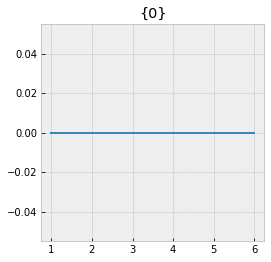

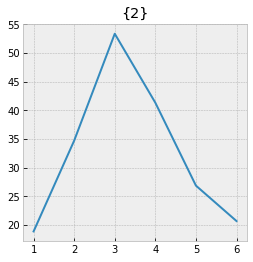

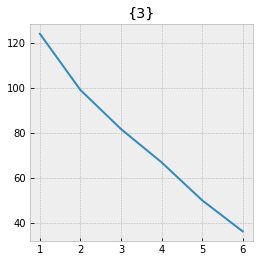

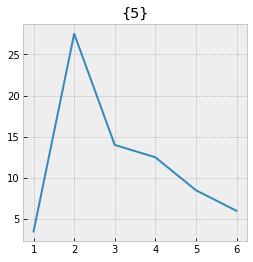

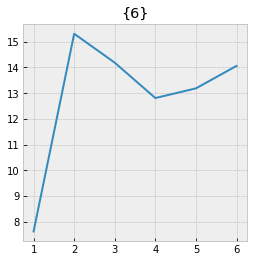

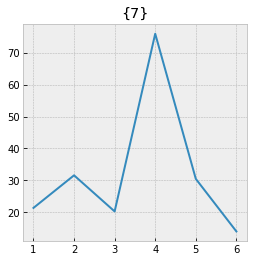

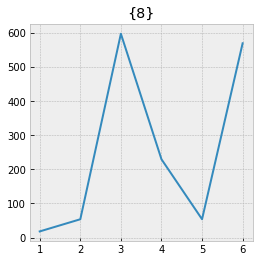

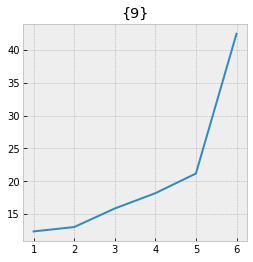

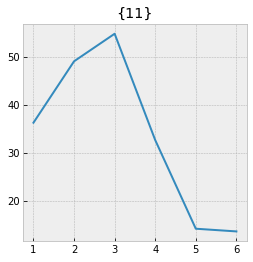

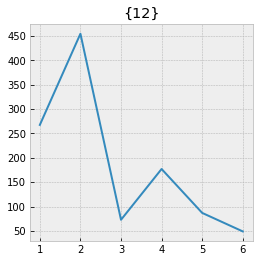

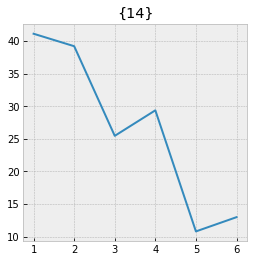

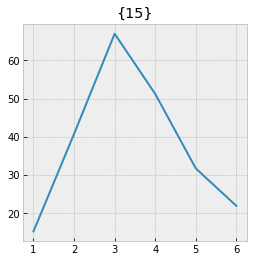

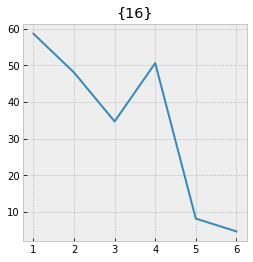

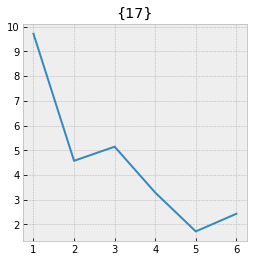

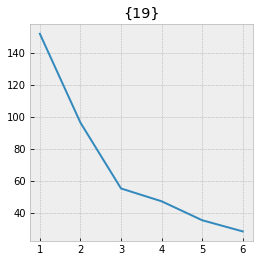

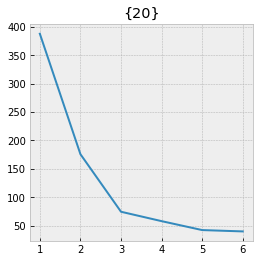

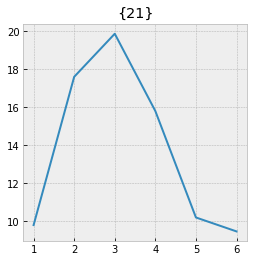

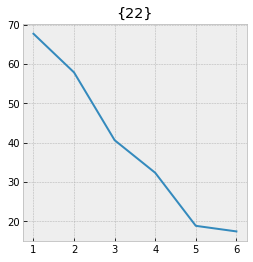

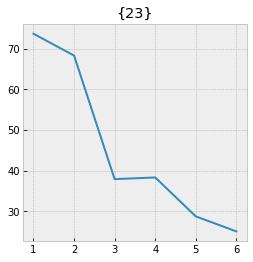

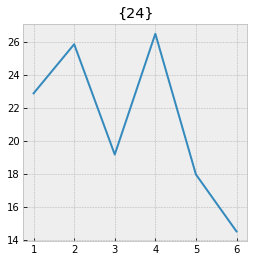

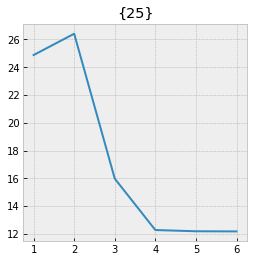

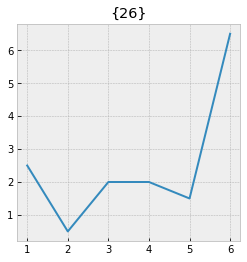

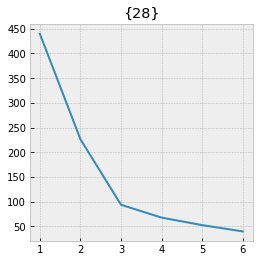

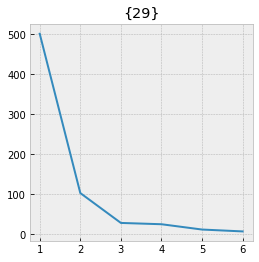

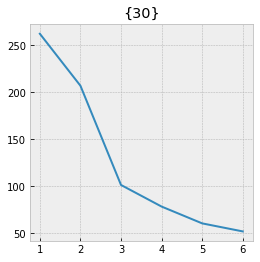

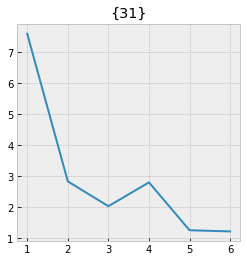

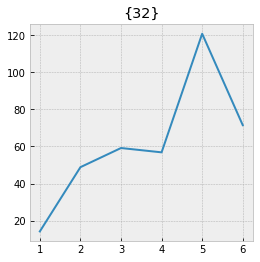

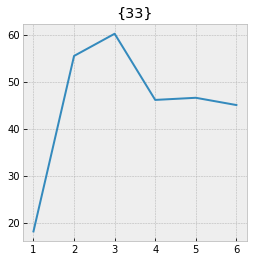

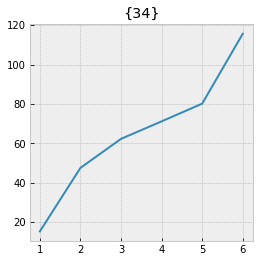

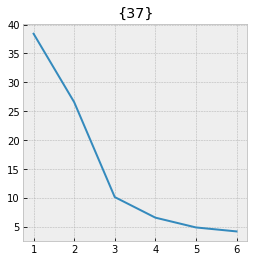

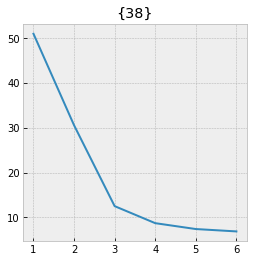

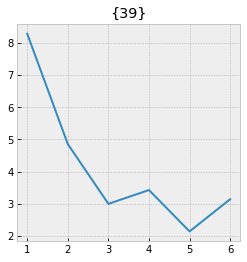

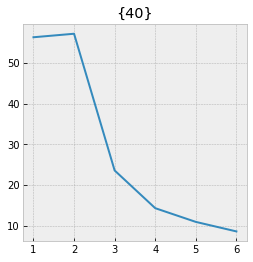

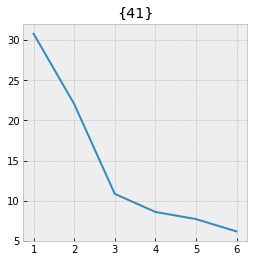

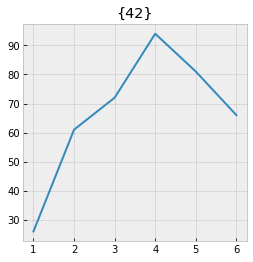

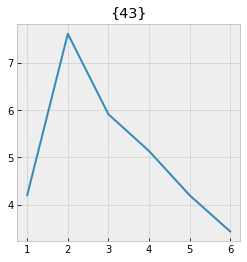

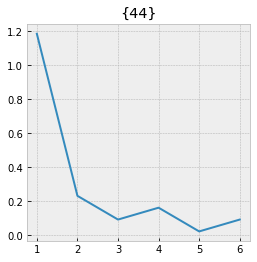

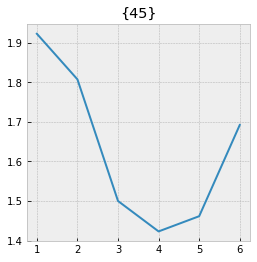

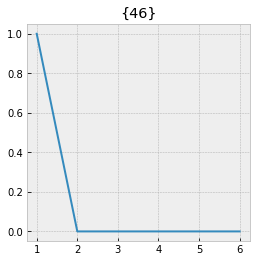

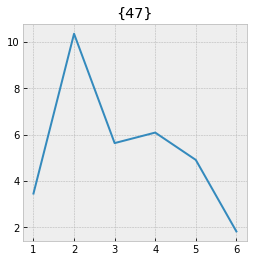

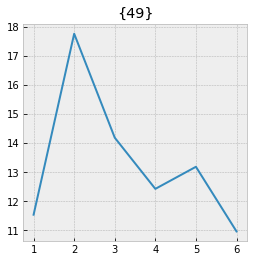

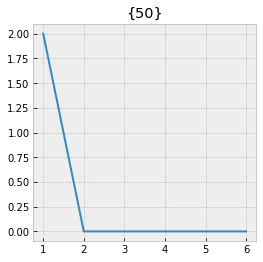

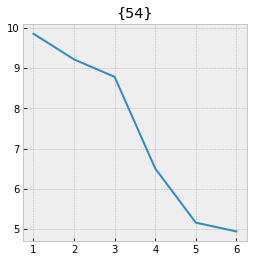

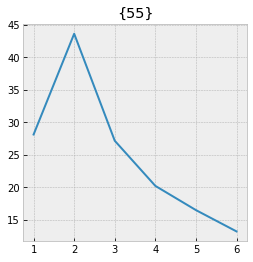

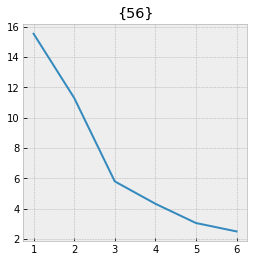

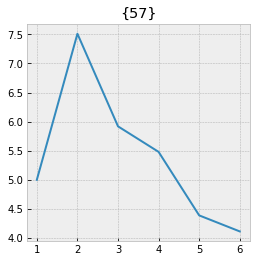

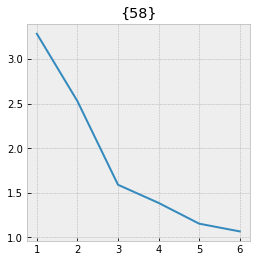

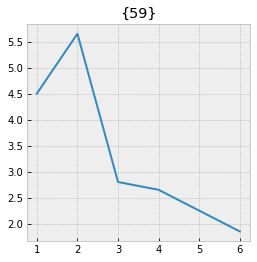

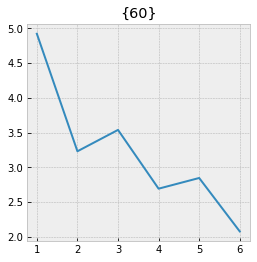

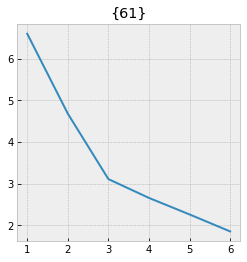

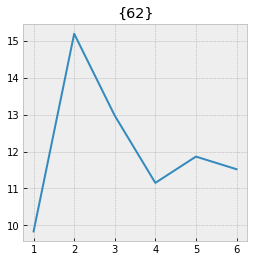

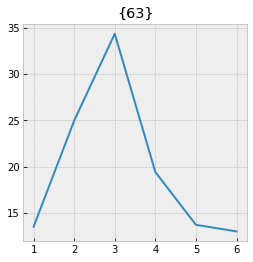

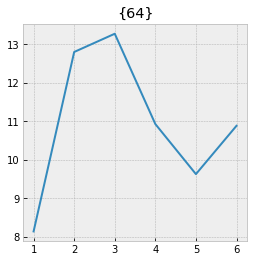

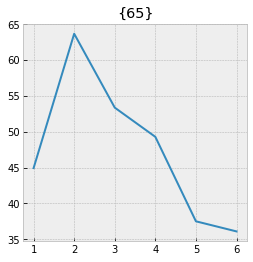

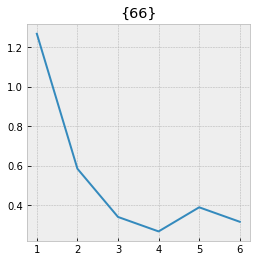

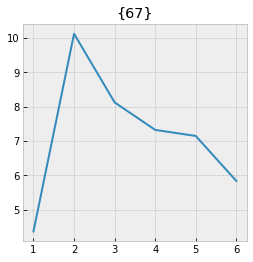

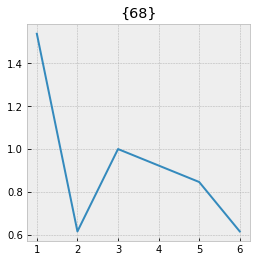

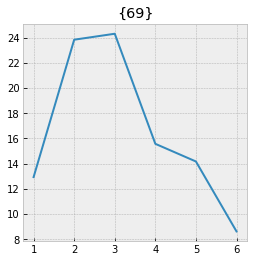

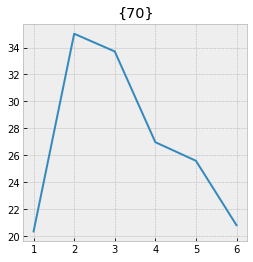

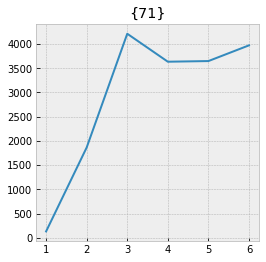

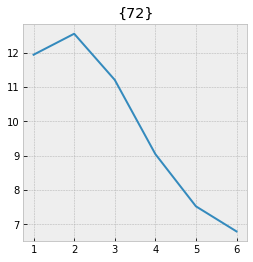

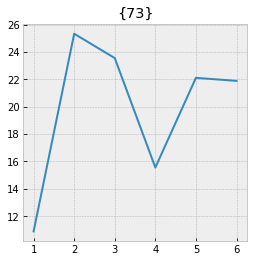

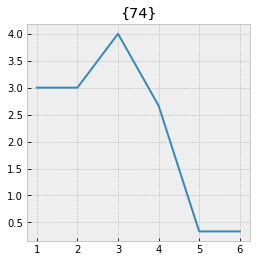

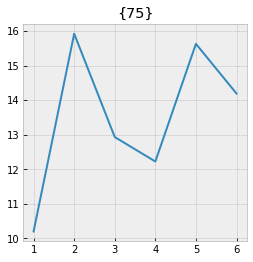

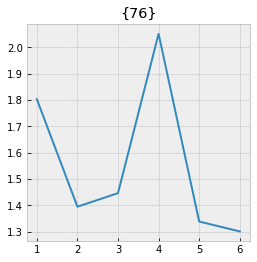

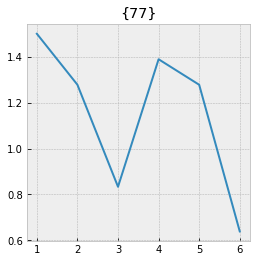

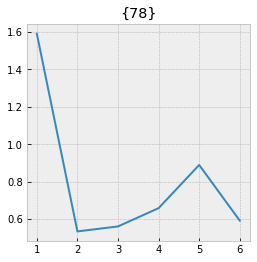

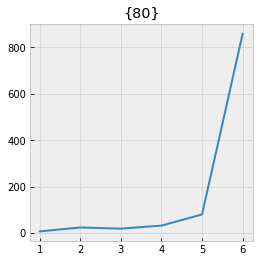

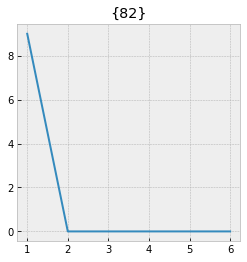

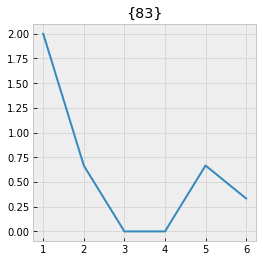

In [44]:
### important to note that we will need to adjust on a monthly basis product the first month 
### base on the day of the first sales of the day and how many days it sales
### If it sales 50 units in the first month but in only 10 days so it's a 150 unit per month rate.
### Chart first 6 month mean unit sale by category
DFfirst6msalesbycatmean=DFfirst6msalesbycat.groupby(['item_category_id']).agg("mean")
dff6m=DFfirst6msalesbycatmean.T# transpose for corr
for col2_idx, column2 in enumerate(dff6m.columns):
    fig, axes = plt.subplots(1, 1, figsize=(4, 4))
    axes.plot(dff6m[column2])
    axes.set_title( {column2})
    #dff6m[column2].plot(legend=True, label="mean monthly unit by store"


We see that for many category sales a deacreasing very fast afther one or two months but for some category they are increasing we most probably 

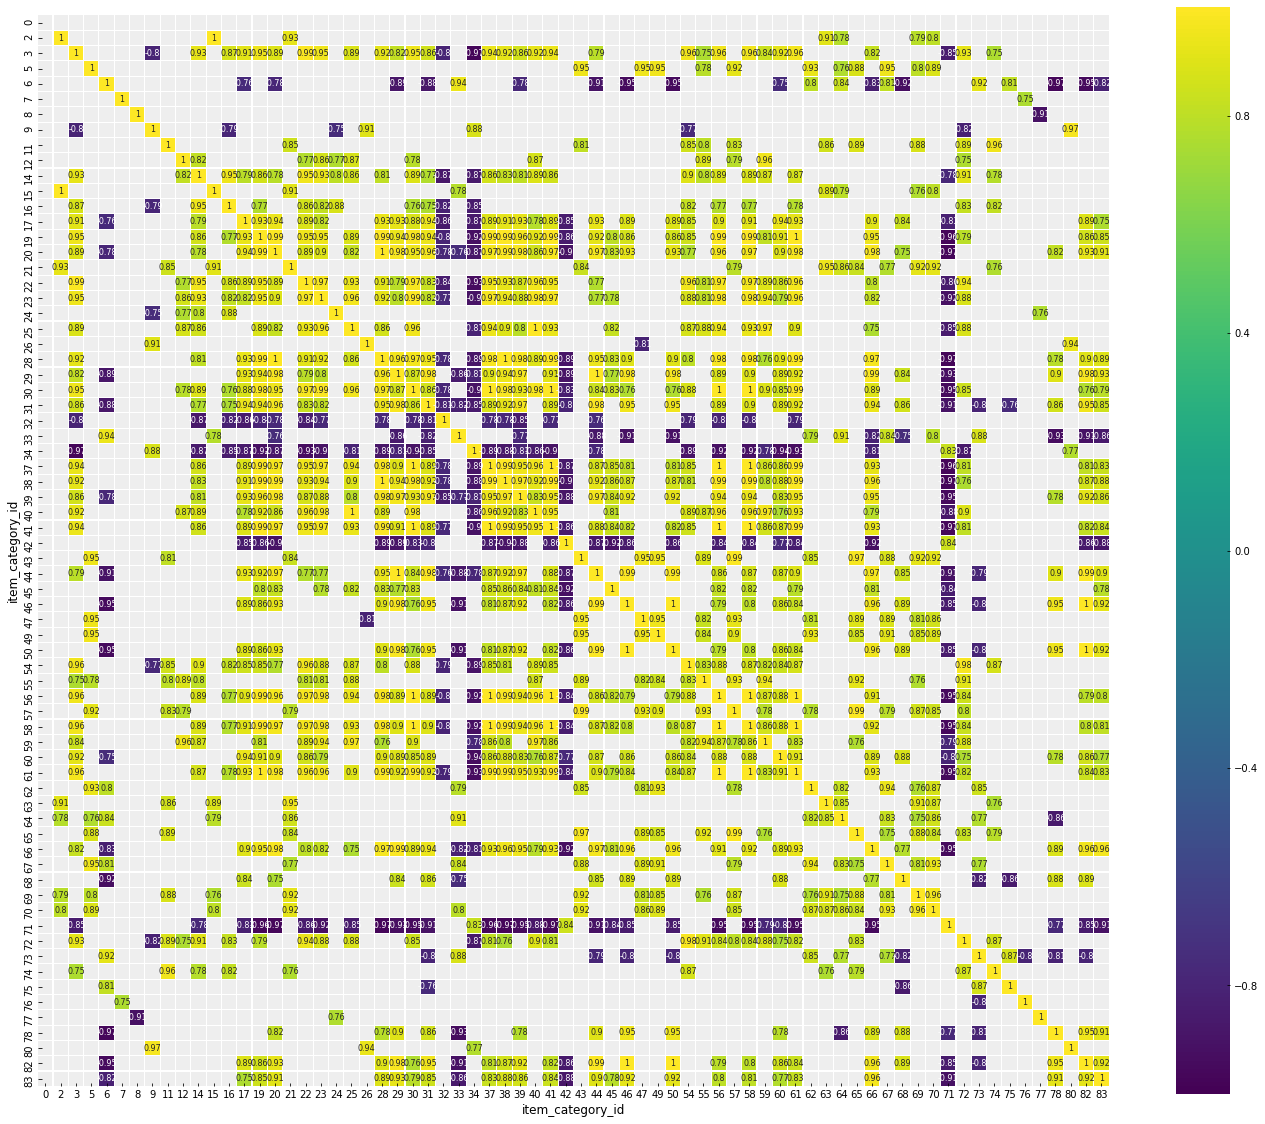

In [45]:
### first 6 month corr by category
### corr between product and category will be useful to forecast new item
### not that usefull we should try to get the average corrolation by item in category 
### and use category corrolation to predict category with low number of item to improve predictabiliy

#dff6m=DFfirst6msalesbycatmean.T# transpose for corr
corr = dff6m.corr()
#corravg=corr.mean()
plt.figure(figsize=(24, 20))

sns.heatmap(corr[(corr >= 0.75) | (corr <= -0.75)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [46]:
#we see that category are different than other they increase sale in time
#this is to see other item thah have a similar corralation with category 80 and 8
corr80 = dff6m.corr()[80][:]
corr80=corr80.sort_values(ascending=False)
corr80.head(10)

item_category_id
80    1.000000
9     0.973223
26    0.935555
34    0.771551
8     0.565528
71    0.361388
6     0.239965
32    0.205922
73    0.203245
75    0.198303
Name: 80, dtype: float64

In [47]:
corr8 = dff6m.corr()[8][:]
corr8=corr8.sort_values(ascending=False)
corr8.head(10)

item_category_id
8     1.000000
71    0.698753
26    0.617416
34    0.607593
9     0.579852
80    0.565528
64    0.521970
33    0.469950
6     0.420078
15    0.416794
Name: 8, dtype: float64

In [48]:
#we will transforme our sale data by item by date into sale data by item by day since the item relase to forcast sales base
# base past sale of similar product of the same age.

dfSales['date'] =pd.to_datetime(dfSales.date)
dfSales=dfSales.sort_values(by="date", ascending=True)

In [49]:
#remove october from the sale datframe
dfSales=dfSales.loc[lambda df1: df1.date_block_num <= 32,:]

In [50]:
#we get the first day of sales for every item with min agg
firstDay=dfSales.groupby(["item_id"])
firstDay=firstDay.agg({ "date" : 'min',"date_block_num" : 'min', 'item_cnt_day' : 'sum' })
firstDay=firstDay.rename(columns={"date" : "fdate"})
firstDay=firstDay.rename(columns={"item_cnt_day" : "total_cnt"})
firstDay.head(5)

fdate  date_block_num  total_cnt
item_id                                      
0       2014-09-01              20        1.0
1       2014-04-02              15        6.0
2       2014-08-24              19        2.0
3       2014-07-05              18        2.0
4       2014-09-19              20        1.0

In [51]:
#sort item by day out to see if we got lot of new product
firstDay["days_out"] = firstDay.fdate.apply(lambda df1: (datetime(2015, 9, 30) - df1 )/ np.timedelta64(1, 'D')) 
firstDay['days_out']=pd.to_numeric(firstDay['days_out'], downcast='integer')
firstDayl30=firstDay.loc[lambda df1: df1.days_out <=60 ,:] 
firstDayl30 = firstDayl30.sort_values(by="total_cnt", ascending=False)
firstDayl30.head(100)


fdate  date_block_num  total_cnt  days_out
item_id                                                
3351    2015-09-22              32     1569.0         8
11354   2015-08-26              31     1138.0        35
4719    2015-09-01              32      829.0        29
4721    2015-09-01              32      663.0        29
3350    2015-09-22              32      652.0         8
3352    2015-09-22              32      622.0         8
4840    2015-09-03              32      593.0        27
1540    2015-08-13              31      535.0        48
20304   2015-08-06              31      462.0        55
4838    2015-09-07              32      409.0        23
20303   2015-08-06              31      395.0        55
8738    2015-08-30              31      335.0        31
13246   2015-08-01              31      324.0        60
5824    2015-08-20              31      321.0        41
15069   2015-09-29              32      301.0         1
14839   2015-08-20              31      300.0        41
4843    2015-09-02              32      265.0        28
15067   2015-09-29              32      264.0         1
5041    2015-09-16              32      249.0        14
8735    2015-08-30              31      248.0        31
8737    2015-09-10              32      240.0        20
11784   2015-08-07              31      220.0        54
3678    2015-08-28              31      196.0        33
14803   2015-09-18              32      188.0        12
15798   2015-08-17              31      179.0        44
3442    2015-08-22              31      174.0        39
2791    2015-09-16              32      165.0        14
8736    2015-08-30              31      164.0        31
12040   2015-08-25              31      163.0        36
11057   2015-08-07              31      163.0        54
...            ...             ...        ...       ...
4720    2015-08-18              31       54.0        43
17162   2015-08-22              31       54.0        39
7499    2015-08-26              31       53.0        35
13332   2015-08-20              31       52.0        41
3599    2015-09-18              32       52.0        12
13218   2015-08-17              31       51.0        44
13340   2015-09-09              32       51.0        21
4722    2015-09-03              32       51.0        27
13339   2015-09-08              32       50.0        22
22163   2015-08-07              31       49.0        54
15511   2015-08-15              31       49.0        46
2671    2015-08-06              31       49.0        55
7526    2015-08-13              31       46.0        48
3598    2015-09-18              32       45.0        12
13233   2015-08-18              31       44.0        43
14421   2015-09-05              32       44.0        25
7067    2015-08-08              31       43.0        53
5670    2015-09-13              32       41.0        17
13237   2015-08-18              31       41.0        43
2063    2015-08-15              31       40.0        46
19431   2015-09-09              32       40.0        21
2788    2015-09-17              32       40.0        13
5044    2015-09-16              32       39.0        14
13463   2015-08-20              31       38.0        41
6301    2015-09-17              32       38.0        13
12080   2015-08-26              31       37.0        35
16494   2015-08-21              31       37.0        40
3917    2015-09-24              32       36.0         6
19705   2015-08-06              31       35.0        55
10037   2015-08-16              31       35.0        45

[100 rows x 4 columns]

We have more than 100 with less than 60 day of data we will need to forcast them with other similar product past data

In [52]:

dfItemCat = pd.read_csv('item_categories.csv')
dfItems = pd.read_csv('items.csv')
dfItems = pd.merge( dfItems , firstDay, on='item_id')
dfItems=dfItems.drop(columns=['date_block_num'])

#dfItems.info()

In [53]:
dfSales = pd.read_csv('sales_train.csv')
dfSales.date=dfSales.date.apply(lambda df1:datetime.strptime(df1, '%d.%m.%Y'))
dfSales= pd.merge(dfSales, dfItems , on=['item_id'])

dfSales=dfSales.loc[lambda df1: df1.date_block_num <= 32,:]
dfSales.sort_values(by="date", ascending=False)
dfSales.head(5)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154       999.0           1.0   
1 2013-01-23               0       24    22154       999.0           1.0   
2 2013-01-20               0       27    22154       999.0           1.0   
3 2013-01-02               0       25    22154       999.0           1.0   
4 2013-01-03               0       25    22154       999.0           1.0   

           item_name  item_category_id      fdate  total_cnt  days_out  
0  ЯВЛЕНИЕ 2012 (BD)                37 2013-01-02       54.0      1001  
1  ЯВЛЕНИЕ 2012 (BD)                37 2013-01-02       54.0      1001  
2  ЯВЛЕНИЕ 2012 (BD)                37 2013-01-02       54.0      1001  
3  ЯВЛЕНИЕ 2012 (BD)                37 2013-01-02       54.0      1001  
4  ЯВЛЕНИЕ 2012 (BD)                37 2013-01-02       54.0      1001

In [54]:
dfmonth = pd.DataFrame({'date_block_num': ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18'
                                           ,'19','20','21','22','23','24','25','26','27','28','29','30','31','32','33'],
                        'month': ['1','2','3','4','5','6','7','8','9','10','11','12','1','2','3','4','5','6','7','8','9','10'
                                  ,'11','12','1','2','3','4','5','6','7','8','9','10']})
dfmonth=dfmonth.astype(int)
dfSales = pd.merge(dfSales, dfmonth , on='date_block_num')


dfSales.head(5)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154       999.0           1.0   
1 2013-01-23               0       24    22154       999.0           1.0   
2 2013-01-20               0       27    22154       999.0           1.0   
3 2013-01-02               0       25    22154       999.0           1.0   
4 2013-01-03               0       25    22154       999.0           1.0   

           item_name  item_category_id      fdate  total_cnt  days_out  month  
0  ЯВЛЕНИЕ 2012 (BD)                37 2013-01-02       54.0      1001      1  
1  ЯВЛЕНИЕ 2012 (BD)                37 2013-01-02       54.0      1001      1  
2  ЯВЛЕНИЕ 2012 (BD)                37 2013-01-02       54.0      1001      1  
3  ЯВЛЕНИЕ 2012 (BD)                37 2013-01-02       54.0      1001      1  
4  ЯВЛЕНИЕ 2012 (BD)                37 2013-01-02       54.0      1001      1

In [55]:
#we put the age of the product (days out) for every sales in dfsales
dfSales["days_out"] =(dfSales['date'] - dfSales['fdate'])/ np.timedelta64(1, 'D')
dfSales=dfSales.sort_values(by="date_block_num", ascending=False)
dfSales.head(5)

date  date_block_num  shop_id  item_id  item_price  \
1041281 2015-09-30              32       25    21937      1549.0   
1007563 2015-09-28              32       12    15575      7399.0   
1007561 2015-09-01              32        7    20091       169.0   
1007560 2015-09-01              32       53    20091       169.0   
1007559 2015-09-29              32       47    20091       169.0   

         item_cnt_day                              item_name  \
1041281           1.0     Шапка Adventure Time Finn плюшевая   
1007563           1.0  НАУТИЛУС ПОМПИЛИУС  Коллекция  2  6LP   
1007561           1.0          УНИВЕРСИТЕТ МОНСТРОВ (регион)   
1007560           1.0          УНИВЕРСИТЕТ МОНСТРОВ (регион)   
1007559           1.0          УНИВЕРСИТЕТ МОНСТРОВ (регион)   

         item_category_id      fdate  total_cnt  days_out  month  
1041281                61 2015-09-30        1.0       0.0      9  
1007563                58 2014-04-26       23.0     520.0      9  
1007561                40 2014-04-11      365.0     508.0      9  
1007560                40 2014-04-11      365.0     508.0      9  
1007559                40 2014-04-11      365.0     536.0      9

In [56]:
#We create a sample of data from product with more than 10 unit sales and that have been relasesed after 2013, 4,1 
dfNewSalesmodel=dfSales.loc[lambda df1: df1.total_cnt >= 10,:]
dfNewSalesmodel=dfNewSalesmodel.loc[lambda df1: df1.fdate >= datetime(2013, 4,1),:]
dfNewSalesmodel['days_out']=pd.to_numeric(dfNewSalesmodel['days_out'], downcast='integer')
dfNewSalesmodel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470698 entries, 1007563 to 431400
Data columns (total 12 columns):
date                1470698 non-null datetime64[ns]
date_block_num      1470698 non-null int64
shop_id             1470698 non-null int64
item_id             1470698 non-null int64
item_price          1470698 non-null float64
item_cnt_day        1470698 non-null float64
item_name           1470698 non-null object
item_category_id    1470698 non-null int64
fdate               1470698 non-null datetime64[ns]
total_cnt           1470698 non-null float64
days_out            1470698 non-null int16
month               1470698 non-null int32
dtypes: datetime64[ns](2), float64(3), int16(1), int32(1), int64(4), object(1)
memory usage: 131.8+ MB


In [57]:
#we create a pivot table from all the sale for all the item we got all the sales in all shop for every signle
#day since the first sale
Newsales_by_ID = dfNewSalesmodel.pivot_table(index=['item_id','item_category_id','fdate'],values=['item_cnt_day'],columns=['days_out'],
                                       aggfunc={'item_cnt_day':np.sum}, fill_value=0).reset_index()

Newsales_by_ID.info()
Newsales_by_ID.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7295 entries, 0 to 7294
Columns: 914 entries, (item_id, ) to (item_cnt_day, 910)
dtypes: datetime64[ns](1), int64(913)
memory usage: 50.9 MB


item_id item_category_id item_cnt_day               \
days_out                                           0            1   
count      7295.000000      7295.000000  7295.000000  7295.000000   
mean      11357.464016        44.350788    10.798903     7.467032   
std        6278.027064        16.456486    81.463435    52.683013   
min          38.000000         2.000000     1.000000    -1.000000   
25%        5814.500000        31.000000     1.000000     0.000000   
50%       11587.000000        40.000000     1.000000     1.000000   
75%       16588.000000        58.000000     2.000000     3.000000   
max       22167.000000        80.000000  3825.000000  2005.000000   

                                                                           \
days_out            2            3            4            5            6   
count     7295.000000  7295.000000  7295.000000  7295.000000  7295.000000   
mean         5.724195     4.814119     4.190679     3.596299     3.120768   
std         23.898518    18.036089    15.097979    11.343214     9.526352   
min         -1.000000    -1.000000    -3.000000    -1.000000    -1.000000   
25%          0.000000     0.000000     0.000000     0.000000     0.000000   
50%          1.000000     1.000000     1.000000     1.000000     1.000000   
75%          3.000000     3.000000     3.000000     3.000000     3.000000   
max        594.000000   572.000000   541.000000   271.000000   230.000000   

                       ...                                         \
days_out            7  ...          901          902          903   
count     7295.000000  ...  7295.000000  7295.000000  7295.000000   
mean         3.203838  ...     0.000822     0.000411     0.000822   
std         11.640711  ...     0.028669     0.020276     0.040553   
min         -1.000000  ...     0.000000     0.000000     0.000000   
25%          0.000000  ...     0.000000     0.000000     0.000000   
50%          1.000000  ...     0.000000     0.000000     0.000000   
75%          3.000000  ...     0.000000     0.000000     0.000000   
max        626.000000  ...     1.000000     1.000000     3.000000   

                                                                           \
days_out          904          905          906          907          908   
count     7295.000000  7295.000000  7295.000000  7295.000000  7295.000000   
mean         0.001097     0.000411     0.000685     0.000411     0.000548   
std          0.082787     0.020276     0.030971     0.026179     0.028676   
min          0.000000     0.000000     0.000000     0.000000     0.000000   
25%          0.000000     0.000000     0.000000     0.000000     0.000000   
50%          0.000000     0.000000     0.000000     0.000000     0.000000   
75%          0.000000     0.000000     0.000000     0.000000     0.000000   
max          7.000000     1.000000     2.000000     2.000000     2.000000   

                                    
days_out          909          910  
count     7295.000000  7295.000000  
mean         0.000411     0.000411  
std          0.026179     0.026179  
min          0.000000     0.000000  
25%          0.000000     0.000000  
50%          0.000000     0.000000  
75%          0.000000     0.000000  
max          2.000000     2.000000  

[8 rows x 913 columns]

In [58]:
#pivot table with date block month by days out 
Newsales_by_ID_db = dfNewSalesmodel.pivot_table(index=['item_id','item_category_id','fdate'],values=['date_block_num'],columns=['days_out'],
                                       aggfunc=np.mean, fill_value=0).reset_index()

Newsales_by_ID_db.head(5)

item_id item_category_id      fdate date_block_num                 \
days_out                                                  0  1   2   3   4   
0             38               41 2014-07-11             18  0   0   0   0   
1             62               37 2014-03-19             14  0   0   0   0   
2             64               40 2014-08-30             19  0  20  20  20   
3             65               37 2013-04-11              3  0   3   0   0   
4             66               37 2013-04-11              3  3   3   0   0   

                  ...                                          
days_out   5   6  ... 901 902 903 904 905 906 907 908 909 910  
0          0  18  ...   0   0   0   0   0   0   0   0   0   0  
1          0   0  ...   0   0   0   0   0   0   0   0   0   0  
2         20   0  ...   0   0   0   0   0   0   0   0   0   0  
3          3   0  ...   0   0   0   0   0   0   0   0   0   0  
4          3   3  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 914 columns]

In [59]:
#pivot table with  month of the year by days out 
Newsales_by_ID_ymonth = dfNewSalesmodel.pivot_table(index=['item_id','item_category_id','fdate'],values=['month'],columns=['days_out'],
                                       aggfunc=np.mean, fill_value=0).reset_index()

Newsales_by_ID_ymonth.head(10)

item_id item_category_id      fdate month                    ...      \
days_out                                         0  1  2  3  4  5  6  ... 901   
0             38               41 2014-07-11     7  0  0  0  0  0  7  ...   0   
1             62               37 2014-03-19     3  0  0  0  0  0  0  ...   0   
2             64               40 2014-08-30     8  0  9  9  9  9  0  ...   0   
3             65               37 2013-04-11     4  0  4  0  0  4  0  ...   0   
4             66               37 2013-04-11     4  4  4  0  0  4  4  ...   0   
5             67               40 2014-08-30     8  0  9  0  9  0  0  ...   0   
6             69               54 2015-04-09     4  4  4  4  4  4  4  ...   0   
7             70               49 2015-04-13     4  0  4  4  4  4  4  ...   0   
8             71               37 2013-09-15     9  0  0  0  0  0  0  ...   0   
9             74               37 2013-11-11    11  0  0  0  0  0  0  ...   0   

                                              
days_out 902 903 904 905 906 907 908 909 910  
0          0   0   0   0   0   0   0   0   0  
1          0   0   0   0   0   0   0   0   0  
2          0   0   0   0   0   0   0   0   0  
3          0   0   0   0   0   0   0   0   0  
4          0   0   0   0   0   0   0   0   0  
5          0   0   0   0   0   0   0   0   0  
6          0   0   0   0   0   0   0   0   0  
7          0   0   0   0   0   0   0   0   0  
8          0   0   0   0   0   0   0   0   0  
9          0   0   0   0   0   0   0   0   0  

[10 rows x 914 columns]

In [60]:
#pivot table with  item price by days out 
Newsales_by_ID_price = dfNewSalesmodel.pivot_table(index=['item_id','item_category_id','fdate'],values=['item_price']
                                                   ,columns=['days_out'],
                                       aggfunc=np.mean, fill_value=0).reset_index()

Newsales_by_ID_price.head()


item_id item_category_id      fdate item_price                       \
days_out                                              0      1      2      3   
0             38               41 2014-07-11     2399.0    0.0    0.0    0.0   
1             62               37 2014-03-19      499.0    0.0    0.0    0.0   
2             64               40 2014-08-30      149.0    0.0  149.0  149.0   
3             65               37 2013-04-11      399.0    0.0  399.0    0.0   
4             66               37 2013-04-11      399.0  399.0  399.0    0.0   

                                ...                                           
days_out      4      5       6  ... 901 902  903 904 905 906 907 908 909 910  
0           0.0    0.0  2399.0  ...   0   0  0.0   0   0   0   0   0   0   0  
1           0.0    0.0     0.0  ...   0   0  0.0   0   0   0   0   0   0   0  
2         149.0  149.0     0.0  ...   0   0  0.0   0   0   0   0   0   0   0  
3           0.0  399.0     0.0  ...   0   0  0.0   0   0   0   0   0   0   0  
4           0.0  399.0   399.0  ...   0   0  0.0   0   0   0   0   0   0   0  

[5 rows x 914 columns]

In [61]:
#sale by item by shop for every day out

Newsales_by_ID_byshop = dfNewSalesmodel.pivot_table(index=['item_id','item_category_id','fdate','shop_id'],values=['item_cnt_day'],columns=['days_out'],
                                       aggfunc={'item_cnt_day':np.sum}, fill_value=0).reset_index()
Newsales_by_ID_byshop.head()

item_id item_category_id      fdate shop_id item_cnt_day              \
days_out                                                        0  1  2  3  4   
0             38               41 2014-07-11       4            0  0  0  0  0   
1             38               41 2014-07-11       6            0  0  0  0  0   
2             38               41 2014-07-11      10            0  0  0  0  0   
3             38               41 2014-07-11      12            0  0  0  0  0   
4             38               41 2014-07-11      13            0  0  0  0  0   

             ...                                          
days_out  5  ... 901 902 903 904 905 906 907 908 909 910  
0         0  ...   0   0   0   0   0   0   0   0   0   0  
1         0  ...   0   0   0   0   0   0   0   0   0   0  
2         0  ...   0   0   0   0   0   0   0   0   0   0  
3         0  ...   0   0   0   0   0   0   0   0   0   0  
4         0  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 915 columns]

In [62]:
### Group by category average by days_out to get daily sales by category model.
Newsales_by_Cat = dfNewSalesmodel.pivot_table(index=['item_category_id'],values=['item_cnt_day'],columns=['days_out'],
                                       aggfunc=np.sum, fill_value=0).reset_index()

Newsales_by_Cat.head(5)

item_category_id item_cnt_day                                     \
days_out                             0    1    2    3    4    5    6    7   
0                       2           27   14   14   29   28   26   24   32   
1                       3          539  195  114  130  164  150  156  143   
2                       5            3    0    2    0    1    0    0    0   
3                       6           16    5   11    6   11   12   12    3   
4                       7          160   30   36   35   31   23   28   39   

               ...                                          
days_out    8  ... 901 902 903 904 905 906 907 908 909 910  
0          27  ...   0   0   0   0   0   0   0   0   0   0  
1         186  ...   0   0   0   0   0   0   0   0   0   0  
2           0  ...   0   0   0   0   0   0   0   0   0   0  
3           8  ...   0   0   0   0   0   0   0   0   0   0  
4          40  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 912 columns]

In [63]:
#item cnt by days out for every category 
Newsales_by_Catstd = dfNewSalesmodel.pivot_table(index=['item_category_id'],values=['item_cnt_day'],columns=['days_out'],
                                       aggfunc=np.std, fill_value=0).reset_index()

Newsales_by_Catstd.head(5)

item_category_id item_cnt_day                                \
days_out                             0         1         2         3   
0                       2     0.196116  0.277350  0.000000  0.188982   
1                       3     4.298195  1.500519  0.707554  0.853592   
2                       5     0.000000  0.000000  0.000000  0.000000   
3                       6     0.000000  0.500000  0.316228  0.000000   
4                       7     2.644272  0.262265  0.373878  0.171499   

                                                           ...               \
days_out         4         5         6         7        8  ...  898 899 901   
0         0.271746  0.200000  0.294245  0.365148  0.00000  ...  0.0   0   0   
1         0.865463  0.758281  0.628205  0.761120  1.08349  ...  0.0   0   0   
2         0.000000  0.000000  0.000000  0.000000  0.00000  ...  0.0   0   0   
3         0.000000  0.000000  0.301511  0.000000  0.00000  ...  0.0   0   0   
4         0.456045  0.418854  0.587137  0.468209  0.42997  ...  0.0   0   0   

                                       
days_out 903  904 906 907 908 909 910  
0          0  0.0   0   0   0   0   0  
1          0  0.0   0   0   0   0   0  
2          0  0.0   0   0   0   0   0  
3          0  0.0   0   0   0   0   0  
4          0  0.0   0   0   0   0   0  

[5 rows x 908 columns]

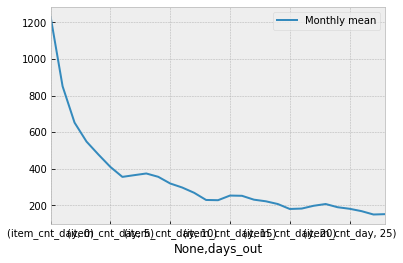

In [64]:
#chart by age for all the category by store average
Newsales_by_Cat.mean()[1:30].plot(legend=True, label="Monthly mean")


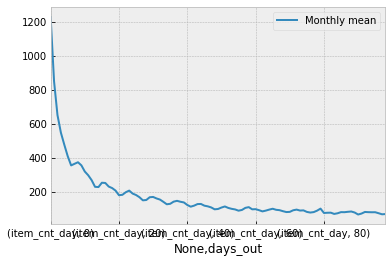

In [65]:
#chart  by age for all the category by store average
Newsales_by_Cat.mean()[1:100].plot(legend=True, label="Monthly mean")


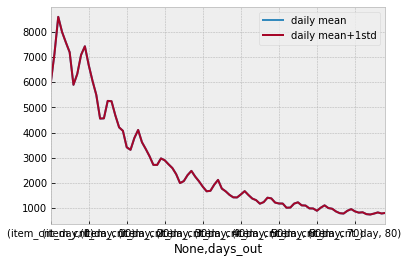

In [66]:
#chart by age for the category 40 with +1 std
Newsales_by_Cat40=Newsales_by_Cat.loc[lambda df1: df1.item_category_id == 40,:]
Newsales_by_Cat40.sum()[1:90].plot(legend=True, label="daily mean")
Newsales_by_Catstd40=Newsales_by_Catstd.loc[lambda df1: df1.item_category_id == 40,:]
(Newsales_by_Cat40.sum()[1:90]+Newsales_by_Catstd40.sum()[1:90]).plot(legend=True, label="daily mean+1std")

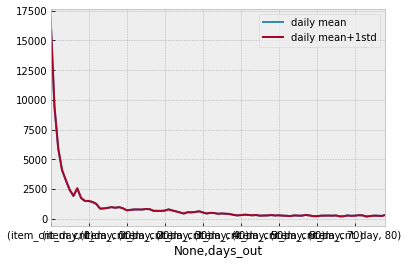

In [67]:
#chart by age for the category 20 with +1 std
Newsales_by_Cat20=Newsales_by_Cat.loc[lambda df1: df1.item_category_id == 20,:]
Newsales_by_Cat20.sum()[1:90].plot(legend=True, label="daily mean")
Newsales_by_Catstd20=Newsales_by_Catstd.loc[lambda df1: df1.item_category_id == 20,:]
(Newsales_by_Cat20.sum()[1:90]+Newsales_by_Catstd20.sum()[1:90]).plot(legend=True, label="daily mean+1std")
#Newsales_by_Cat20.sum()[1:300].plot(legend=True, label="daily mean")

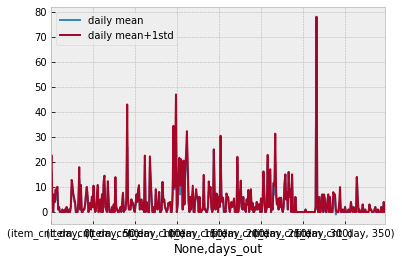

In [68]:
#chart by age for the category 55 with +1 std
Newsales_by_Cat55=Newsales_by_Cat.loc[lambda df1: df1.item_category_id == 9,:]
#Newsales_by_Cat55.sum()[1:30].plot(legend=True, label="daily mean")
Newsales_by_Cat55.sum()[1:400].plot(legend=True, label="daily mean")
Newsales_by_Catstd55=Newsales_by_Catstd.loc[lambda df1: df1.item_category_id == 9,:]
(Newsales_by_Cat55.sum()[1:400]+Newsales_by_Catstd55.sum()[1:400]).plot(legend=True, label="daily mean+1std")

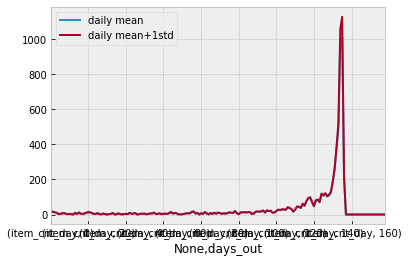

In [69]:
#chart by age for the category 30 with +1 std
Newsales_by_Cat30=Newsales_by_Cat.loc[lambda df1: df1.item_category_id == 80,:]
Newsales_by_Cat30.sum()[1:180].plot(legend=True, label="daily mean")
Newsales_by_Catstd30=Newsales_by_Catstd.loc[lambda df1: df1.item_category_id ==80,:]
(Newsales_by_Cat30.sum()[1:180]+Newsales_by_Catstd30.sum()[1:180]).plot(legend=True, label="daily mean+1std")

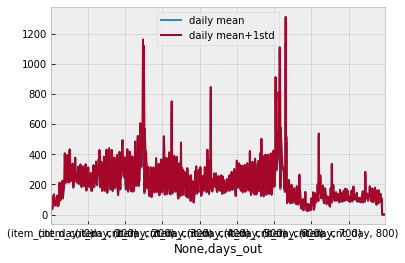

In [70]:
#chart by age for the category 30 with +1 std
Newsales_by_Cat30=Newsales_by_Cat.loc[lambda df1: df1.item_category_id == 71,:]
Newsales_by_Cat30.sum()[1:900].plot(legend=True, label="daily mean")
Newsales_by_Catstd30=Newsales_by_Catstd.loc[lambda df1: df1.item_category_id ==71,:]
(Newsales_by_Cat30.sum()[1:900]+Newsales_by_Catstd30.sum()[1:900]).plot(legend=True, label="daily mean+1std")

category  8 and 80 is very different from other category, It's ticket for event so it's doing an exponential expantion going into the event and drop to 0 after the event so we need a different model to predict this category.
date of the event is in the item name so we need to translate russian month into datetime and build an exponential model base on time before the event   

##Create a test on October data to verify forcast and model
# we will try to predict by item by store and by item for overall the shops and distributes to shops by market shares to see witch method is the best our itutions is data by shop have to many 0 and many item will not have enought data to prdict at shop level. We will use ARIMA and linear regression on other item from the same category to predict sales by item

In [71]:
### fonction to forcat item sale by the age of the product with similar product from same category
import time

def next30daySalesByMeanSTD(id,nday,now,db,month,dfItems,Newsales_by_Cat,Newsales_by_Catstd,Newsales_by_ID):
    print(id)
    dfforc=pd.DataFrame()#df to put forcast to be return in the function
    dfforc['item_id']=[id]
    ###################################################################################
    # Lot of data manipilation to create df to train an df to forcast                 #
    now=datetime(2015, 9, 30)
    item=dfItems.loc[lambda df1: df1.item_id ==id,:]                                  #
    idate=item['fdate']
    idate=idate.to_numpy(dtype="datetime64[D]")                                       # 
    idatets=(idate - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  #
    idate=datetime.utcfromtimestamp(idatets)
    dayout= np.asscalar(item['days_out'].to_numpy())                                  #
    if dayout>(now-datetime(2013, 4,1)).days-35:
        dayout=(now-datetime(2013, 4,1)).days -35                                     #
    cat=np.asscalar(item['item_category_id'].to_numpy())
    isale= Newsales_by_ID.loc[lambda df1: df1.item_id ==id,:]                         #
    isale=isale['item_cnt_day']
    sample=Newsales_by_ID.loc[lambda df1: df1.item_category_id ==cat,:]               #
    sample=sample.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
    sample=sample.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]           #
    sampledb=Newsales_by_ID_db.loc[lambda df1: df1.item_category_id ==cat,:]
    sampledb=sampledb.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]        #
    sampledb=sampledb.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]       #
    sampleym=Newsales_by_ID_ymonth.loc[lambda df1: df1.item_category_id ==cat,:]      #
    sampleym=sampleym.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]        #
    sampleym=sampleym.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]       #
    sample2=sample['item_cnt_day']
    sampledb=sampledb['date_block_num']                                               #
    sampleym=sampleym['month']
    ###################################################################################

    X=pd.DataFrame() #df to train
    XF=pd.DataFrame() #df to forc

    #List of columns related to the time periode we want to forcast 
    if dayout<nday:
        col_list=list(range(0,dayout+1))
    else:
        col_list=list(range(dayout-nday,dayout+1))

    if dayout<7:
        lweek_list=list(range(0,dayout+1))
    else:
        lweek_list=list(range(dayout-7,dayout+1))

    fcol_list=list(range(dayout+2,dayout+2+nday))
    #####################################################################################

    X['nt']=sample2[col_list].to_numpy().sum(axis=1)

    if dayout>31: #use autoregressive model
    ############# ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA #################################
        stst = pd.DataFrame()
        stsy = pd.DataFrame()
        sts=dfSales.loc[lambda df1: df1.item_id	 == id,:]
        sts=sts.groupby(['date_block_num']).agg({"item_cnt_day":"sum"})
        sts=sts.rename(columns={'date_block_num' : 'ds', 'item_cnt_day' : 'y'})
        stst['ds']=sts.index
        stst['ds']=stst['ds'].apply(lambda df1: datetime(2013, 1, 1)+relativedelta(months=+df1))
        stsy=(sts['y'].to_numpy())
        stsy=np.log(stsy)#log for stationarity
        if len(stsy)>4 and stsy.std()>0 and stsy.sum()/dayout>1/30:
            if dayout>400 and len(stsy)>12: #model with sesonality               
                pipeline = Pipeline([
                 ('fourier', FourierFeaturizer(k=1, m=12)),
                 ("model", pm.AutoARIMA(seasonal=True,d=1 , suppress_warnings=True, error_action="ignore"))])#auto fit sarima
                pipeline2 = Pipeline([
                ("model", pm.ARIMA(order=(1, 0,0), seasonal_order=(1,0, 0, 12), suppress_warnings=True))]) #basic arima p=1 s=12 
            else: #with no sesonality less than 1 year of data                 
                pipeline = Pipeline([
                 ("model", pm.AutoARIMA(seasonal=False,d=1 , suppress_warnings=True , error_action="ignore"))])#auto fit arima
                pipeline2 = Pipeline([
                ("model", pm.ARIMA(order=(1, 0,0), suppress_warnings=True))])#basic arima p=1   
            
            pipeline.fit(stsy)#fit auto
            pred=pipeline.predict(1)#predict 1 with auto
            pred=np.exp(pred)#inverse log

            pipeline2.fit(stsy)#fit basic
            pred2=pipeline2.predict(1)#predict 1 with basic
            pred2=np.exp(pred2)#inverse log
            
        else:
            pred=[0]
            pred2=[0]

        dfforc['autoARIMA']=max(pred,[0]) 
        dfforc['ARIMA_10012']=max(pred2,[0])
        dfforc['lastmonth']=np.exp(stsy[-1])


    if dayout<800 and len(X.index)>=3:
    ############# LinearRegression LinearRegression LinearRegression LinearRegression   ###################################################

        # X to train XF to forcast                    
        X['LastW']=sample2[lweek_list].to_numpy().sum(axis=1)#sum last 7 day less volatyle than last day
        XF['LastW']=isale[lweek_list].to_numpy().sum(axis=1)
        XF['nt']=isale[col_list].to_numpy().sum(axis=1)
        X['y']=sample2[fcol_list].to_numpy().sum(axis=1)#for all item sum the sales on the same age we try to forcast
        X['db']=sampledb[fcol_list].to_numpy().max(axis=1)#for all item the date_block_num at that same age to adjust to time trend
        XF['db']=db
        m=sampleym[fcol_list].to_numpy().max(axis=1)#m is the month of the coreponding to the age 
        X['mstd']= (((X['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()# mstd is mean std ajusted prediction 
        XF['mstd']= (((XF['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()
        #base on category history and sale history we have for the item we try to 
        X['db']=X['db']*X['mstd'] # db * mstd to adjust forcast to trend
        XF['db']=XF['db']*XF['mstd']
        X['Last']=sample2[dayout].to_numpy()
        XF['Last']=isale[dayout].to_numpy()
        XF=XF.fillna(0)
        if XF['nt'].empty==True or X['nt'].std() ==0:
             dfforc['reg_lin_mul']=XF['LastW']*4.2
        else:
            #we create 12 variable for every month of the year and put mstd in its coresponfing month to catch the seasonality                                           
            for i in range(1,13):
                X['s'+str(i)]=0                                            
            j=0  
            for i in m: 
                if i==0:
                    i=1
                X.loc[j,'s'+str(i)]=X.loc[j,'mstd']
                j=j+1
            Y=X['y'] 
            X=X.fillna(0)
            Y=Y.fillna(0)
            X1=X.drop(columns=['y','mstd','nt'])#drop mstd 'nt'
            X2=X.drop(columns=['y','mstd','db','nt'])#drop mstd 'nt' dt
            X3=X.drop(columns=['y','nt','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12'])#drop mstd 'nt' dt season
            X4=X.drop(columns=['y','nt','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','db','Last'])
            #print(X1)          

            X1=X1.to_numpy()
            X2=X2.to_numpy()
            X3=X3.to_numpy()
            X4=X4.to_numpy()
            Y=Y.to_numpy()
            ###############################################################
            # FIT X Y                
            reg1 = LinearRegression().fit(X1, Y)#build lin reg model 1
            reg2 = LinearRegression().fit(X2, Y)#build lin reg model 2
            reg3 = LinearRegression().fit(X3, Y)#build lin reg model 3
            reg4 = LinearRegression().fit(X4, Y)#build lin reg model 4
            ##                                                            ##
            ################################################################
            
            ##################################################################
            #prepare XF dataframe to forcast 
            for i in range(1,13):                             
                XF['s'+str(i)]=0                                
            XF.loc[0,'s'+str(month)]=XF.loc[0,'mstd']          
            XF=XF.fillna(0) 
            
            XF1=XF.drop(columns=['mstd','nt'])
            XF2=XF.drop(columns=['mstd','db','nt'])
            XF3=XF.drop(columns=['nt','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12'])#drop mstd 'nt' 
            XF4=XF.drop(columns=['nt','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','db','Last'])
            #print(XF1)
            XF1=XF1.to_numpy()                                   
            XF2=XF2.to_numpy()                                   
            XF3=XF3.to_numpy()
            XF4=XF4.to_numpy()
            ##################################################### 
            
            #################################################################
            # FROC
            forc1 =max([0],reg1.predict(XF1))#forcast 1 
            forc2 =max([0],reg2.predict(XF2))#forcast 2
            forc3 =max([0],reg3.predict(XF3))#forcast 3
            forc4 =max([0],reg4.predict(XF4))#forcast 4
            if forc1>np.sum([forc2,forc3,forc4])*2: forc1=[np.sum([forc2,forc3,forc4])/3]
            if forc2>np.sum([forc1,forc3,forc4])*2: forc2=[np.sum([forc1,forc3,forc4])/3]
            if forc3>np.sum([forc2,forc1,forc4])*2: forc3=[np.sum([forc2,forc1,forc4])/3]
            if forc4>np.sum([forc2,forc3,forc1])*2: forc4=[np.sum([forc2,forc3,forc1])/3]
            dfforc['reg_lin_mul1']=forc1# add forcast to forcast 1 dataframe
            dfforc['reg_lin_mul2']=forc2# add forcast to forcast 2 dataframe
            dfforc['reg_lin_mul3']=forc3# add forcast to forcast 3 dataframe
            dfforc['reg_lin_mul4']=forc4# add forcast to forcast 4 dataframe
    #print(dfforc)
    return dfforc

In [72]:
#This is to forcast only one item like the fonction and to take a look at particular issue with shop
def next30dayShopSalesByMeanSTD(id,shop,nday,now,db,month,dfItems,Newsales_by_Cat,Newsales_by_Catstd,Newsales_by_ID):
    #print(id)
    #print(shop)
    
    dfforc=pd.DataFrame()
    dfforc['item_id']=[id]
    dfforc['shop_id']=[shop]
    now=datetime(2015, 9, 30)
    item=dfItems.loc[lambda df1: df1.item_id ==id,:]
    idate=item['fdate']
    idate=idate.to_numpy(dtype="datetime64[D]")
    idatets=(idate - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    idate=datetime.utcfromtimestamp(idatets)
    dayout= np.asscalar(item['days_out'].to_numpy())
    if dayout>(now-datetime(2013, 4,1)).days-35:
        dayout=(now-datetime(2013, 4,1)).days -35
    cat=np.asscalar(item['item_category_id'].to_numpy())
    isale= Newsales_by_ID_byshop.loc[lambda df1: df1.item_id ==id ,:]
    isale= isale.loc[lambda df1: df1.shop_id ==shop ,:]
    isale=isale.set_index('item_id')
    isale=isale['item_cnt_day']
    sample=Newsales_by_ID_byshop.loc[lambda df1: df1.item_category_id ==cat ,:]
    sample=sample.loc[lambda df1:df1.shop_id ==shop,:]
    sample=sample.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
    sample=sample.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]
    sample=sample.set_index('item_id')
    sample2=sample['item_cnt_day']

    X=pd.DataFrame()
    XF=pd.DataFrame()
    if dayout<nday:
        col_list=list(range(0,dayout+1))
    else:
        col_list=list(range(dayout-nday,dayout+1))
    fcol_list=list(range(dayout+2,dayout+2+nday))

    if dayout<7:
        lweek_list=list(range(0,dayout+1))
    else:
        lweek_list=list(range(dayout-7,dayout+1))

    X['nt']=sample2[col_list].to_numpy().sum(axis=1)

    if dayout>31: #use autoregressive model
    ############# ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA #################################
        stst = pd.DataFrame()
        stsy = pd.DataFrame()
        sts=dfSales.loc[lambda df1: df1.item_id	 == id ,:]
        sts=sts.loc[lambda df1:df1.shop_id ==shop,:]
        sts=sts.groupby(['date_block_num']).agg({"item_cnt_day":"sum"})
        sts=sts.rename(columns={'date_block_num' : 'ds', 'item_cnt_day' : 'y'})
        stst['ds']=sts.index
        stst['ds']=stst['ds'].apply(lambda df1: datetime(2013, 1, 1)+relativedelta(months=+df1))
        stsy=(sts['y'].to_numpy())
        stsy=np.log(stsy)#log for stationarity
        if len(stsy)>4 and stsy.std()>0 and stsy.sum()/dayout>1/30:
            if dayout>400 and len(stsy)>12: #model with sesonality               
                pipeline = Pipeline([
                 ('fourier', FourierFeaturizer(k=1, m=12)),
                 ("model", pm.AutoARIMA(seasonal=True,d=1 , suppress_warnings=True))])#auto fit sarima
                pipeline2 = Pipeline([
                ("model", pm.ARIMA(order=(1, 0,0), seasonal_order=(1,0, 0, 12), suppress_warnings=True))]) #basic arima p=1 s=12 
            else: #with no sesonality less than 1 year of data                 
                pipeline = Pipeline([
                 ("model", pm.AutoARIMA(seasonal=False,d=1 , suppress_warnings=True))])#auto fit arima
                pipeline2 = Pipeline([
                ("model", pm.ARIMA(order=(1, 0,0), suppress_warnings=True))])#basic arima p=1   

            pipeline.fit(stsy)#fit auto
            pred=pipeline.predict(1)#predict 1 with auto
            pred=np.exp(pred)#inverse log

            pipeline2.fit(stsy)#fit basic
            pred2=pipeline2.predict(1)#predict 1 with basic
            pred2=np.exp(pred2)#inverse log

        else:
            pred=[0]
            pred2=[0]

        dfforc['autoARIMA']=max(pred,[0]) 
        dfforc['ARIMA_10012']=max(pred2,[0])
        if len(stsy)>0:
            dfforc['lastmonth']=np.exp(stsy[-1])
        else:
            dfforc['lastmonth']=0

    if dayout<800 and len(X.index)>=3:
         # X to train XF to forcast  
            #print(sample2)
            X['LastW']=sample2[lweek_list].to_numpy().sum(axis=1)#sum last 7 day less volatyle than last day
            XF['LastW']=isale[lweek_list].to_numpy().sum(axis=1)
            XF['nt']=isale[col_list].to_numpy().sum(axis=1)
            X['y']=sample2[fcol_list].to_numpy().sum(axis=1)#for all item sum the sales on the same age we try to forcast
     

            X['mstd']= (((X['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()# mstd is mean std ajusted prediction 
            XF['mstd']= (((XF['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()

            X['Last']=sample2[dayout].to_numpy()
            XF['Last']=isale[dayout].to_numpy()
            XF=XF.fillna(0)
            if XF['nt'].empty==True or X['nt'].std() ==0:
                 dfforc['reg_lin_mul']=XF['LastW']*4.2
            else:
                Y=X['y'] 
                X=X.fillna(0)
                Y=Y.fillna(0)            
                X1=X.drop(columns=['y','nt'])#drop mstd 'nt'
                X2=X.drop(columns=['y','mstd','nt'])#drop mstd 'nt' dt
                X3=X.drop(columns=['y','Last'])#drop mstd 'nt' 
                X4=X.drop(columns=['y','nt','Last'])#drop mstd 'nt' dt
                X1=X1.to_numpy()
                X2=X2.to_numpy()
                X3=X3.to_numpy()
                X4=X4.to_numpy()
                Ydf=Y          
                Y=Y.to_numpy()
                ###############################################################
                # FIT X Y 
                reg1 = LinearRegression().fit(X1, Y)#build lin reg model 1
                reg2 = LinearRegression().fit(X2, Y)#build lin reg model 2
                reg3 = LinearRegression().fit(X3, Y)#build lin reg model 3
                reg4 = LinearRegression().fit(X4, Y)#build lin reg model 4
                ##                                                            ##
                ################################################################

                ##################################################################
                #prepare XF dataframe to forcast      
                XF=XF.fillna(0) 
                XF1=XF.drop(columns=['nt'])#drop mstd 'nt'
                XF2=XF.drop(columns=['mstd','nt'])#drop mstd 'nt' dt
                XF3=XF.drop(columns=['Last'])#drop mstd 'nt' 
                XF4=XF.drop(columns=['nt','Last'])#drop mstd 'nt' dt
                XF1=XF1.to_numpy()                                   
                XF2=XF2.to_numpy()                                   
                XF3=XF3.to_numpy()
                XF4=XF4.to_numpy()
                ##################################################### 

                #################################################################
                # FROC

                forc1 =max([0],reg1.predict(XF1))#forcast 1 
                forc2 =max([0],reg2.predict(XF2))#forcast 2
                forc3 =max([0],reg3.predict(XF3))#forcast 3
                forc4 =max([0],reg4.predict(XF4))#forcast 4 
                if forc1>np.sum([forc2,forc3,forc4])*2: forc1=[np.sum([forc2,forc3,forc4])/3]
                if forc2>np.sum([forc1,forc3,forc4])*2: forc2=[np.sum([forc1,forc3,forc4])/3]
                if forc3>np.sum([forc2,forc1,forc4])*2: forc3=[np.sum([forc2,forc1,forc4])/3]
                if forc4>np.sum([forc2,forc3,forc1])*2: forc4=[np.sum([forc2,forc3,forc1])/3]
                dfforc['reg_lin_mul1']=forc1# add forcast to forcast 1 dataframe
                dfforc['reg_lin_mul2']=forc2# add forcast to forcast 2 dataframe
                dfforc['reg_lin_mul3']=forc3# add forcast to forcast 3 dataframe
                dfforc['reg_lin_mul4']=forc4# add forcast to forcast 4 dataframe
    return dfforc

In [73]:
#create a data frame of all the sales with out October
#create a data frame of all the item we need to forcast for October

dfSalesT = pd.read_csv('sales_train.csv')
dftest=pd.read_csv('test.csv')
dfushop=dftest['shop_id'].unique()
dfuitem=dftest['item_id'].unique()

dfSalesT = dfSalesT.loc[lambda df1: df1.date_block_num == 33,:]
itemtoforctest = dfSales.loc[lambda df1: df1.date_block_num == 32,:]
itemtoforctest = itemtoforctest.groupby(['item_id']).agg("sum")
listItemTest = itemtoforctest.index
dfSalesT = dfSalesT.groupby(['item_id']).agg("sum")


for i in listItemTest:
    if i in dfSalesT.index:
        itemtoforctest.loc[i,'item_cnt']=dfSalesT.loc[i,'item_cnt_day']
itemtoforctest=itemtoforctest['item_cnt']
itemtoforctest=itemtoforctest.fillna(0)
itemtoforctest=pd.DataFrame(itemtoforctest)



In [74]:
#create a data frame of all the sales with out October with shop
#create a data frame of all the item we need to forcast for October with shop
#October data will be use to test are models
dfSalesT = pd.read_csv('sales_train.csv')
dftest=pd.read_csv('test.csv')
dfushop=dftest['shop_id'].unique()
dfuitem=dftest['item_id'].unique()

dfSalesT = dfSalesT.loc[lambda df1: df1.date_block_num == 33,:]

itemshoptoforctest = dfSales.loc[lambda df1: df1.date_block_num == 32,:]

itemshoptoforctest = itemshoptoforctest.groupby(['item_id','shop_id']).agg({"item_cnt_day":"sum" })
itemtoforctest = itemtoforctest.groupby(['item_id']).agg("sum")
listItemTest = itemtoforctest.index
dfSalesTis = dfSalesT.groupby(['item_id','shop_id']).agg({"item_cnt_day":"sum"})
for i in listItemTest:
    for s in dfushop:
        if i in dfSalesT.index:
            if s in dfSalesT.index:
                itemshoptoforctest.loc[i,s,'item_cnt']=dfSalesT.loc[i,s,'item_cnt_day']

itemshoptoforctest=itemshoptoforctest.fillna(0)
itemshoptoforctest=pd.DataFrame(itemshoptoforctest)

In [75]:
#Loop to forcat all the total by item for October with fonction next30daySalesByMeanSTD
#remove head and uncoment all the line in hte for loop for full process
#see next30daySalesByMeanSTD for detail 
#this will take from 10 to 30 minutes
forctest = pd.DataFrame()
nday=31
now=datetime(2015, 9, 30)
listItemTest = itemtoforctest.index
for i in listItemTest:
    us=next30daySalesByMeanSTD(i,nday,now,33,10,dfItems,Newsales_by_Cat,Newsales_by_Catstd,Newsales_by_ID)
    forctest=forctest.append(us)
                   
print(forctest.head())

30


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



31


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



32


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



33


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



38


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



42


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



45


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



49


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



51


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



53


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



57


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



59


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



62


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



67


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

69
70


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



79


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



93


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



109


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



113


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



142
149


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



154


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



156


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



167
205
207
211
212
213


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



214
216
217
225
228
231
234


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

239
240
241
248
259


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

269
283
284
288
295
296
299
301


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



308


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



313


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



314
322
324
325


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



334
353
356
388


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



395
407
408


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



413


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

414
415
421
423
448


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



456
464


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



472


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

invalid value encountered in log



477
478
482


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



486


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



491


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



492


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



493


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



494


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



496


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



502
503
504
515
521
522
528


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

537
539
564
576
577
578
581
583
592
618
619
627
636


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



644
675
686
687


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



688


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log



719
781
784


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



787


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



790
792


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

794
797


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



798


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

799
800
801
802


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



803


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



805


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



806


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



809
821
827


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



829


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



832


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



833


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



835


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

837
838


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



839


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

843
848
849


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



853
858
865
867
871
877

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 


889
891
894
896
897
910
916


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



922
925
928
934


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

invalid value encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Use

948
952
958
968


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



969


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



970


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



971


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



972


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



975


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

976
978
982


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



983


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



987


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1007


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1010


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1017


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1018


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1020


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1025


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1026


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1037


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1045
1075


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1077


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1087


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1090


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1099


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1100
1101


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1102


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1108


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1121


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1128
1131


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1132
1133


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1142


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1155
1175


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1177
1178
1179
1180
1183
1199


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

1201


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1202
1204


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1209
1215
1224


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1231
1232


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1233


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1239


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1241


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1247


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1249


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1250
1256


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1257


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



1270
1286


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1288


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1289


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1290


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1293


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1306


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1307


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1315


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1322


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1324


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1325


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1328


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1329


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1332


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1334
1351
1354
1355


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




1364
1373


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1377


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1379


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1384


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1387
1388


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1389


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1390


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1391


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1398


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1400
1406


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1413


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1414


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




1424
1427
1429
1432


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1450


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1453


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1464


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




1465
1466


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1467


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1469


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1471


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1480


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1483


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1484
1485


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1486


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1487


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1490


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1495


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1496


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




1505


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1506


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




1515
1519


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1523


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1534


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1535


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




1537


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1538
1539


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1540
1544


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1545
1546


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1547


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1548


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1555


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1556
1557


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1560
1563


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1564


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1565


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1567


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1568
1569


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1570


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1571
1572


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1573
1576
1588


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1608
1609
1610


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1611


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1617
1619
1625
1670


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1673


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1682


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1686


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1687


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1716


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1717


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1725


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1729


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1730


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1734


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1735


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1740


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1741


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1743


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1753


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1754


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1761


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1772
1775


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1783


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




1788


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1789


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1792


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1798


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1803


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1809


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1810


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1814
1815


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1816
1817


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1829


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1830


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1837


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1846
1847


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1855


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1856


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1857


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1858


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1859
1865


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1866


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1876


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




1877
1878


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

1879
1881


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1905


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1914


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1915


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1916


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




1927
1929
1930
1946


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

1963
1964
1965
1968


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1969


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

1970
1971


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



1988


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




1994
2000


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2013
2031


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




2035


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2036
2039


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2040


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2041


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

2047
2049


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2050


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2056
2059
2060
2062
2063


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2070


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2071


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2073


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2078


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2081
2085
2088


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



2090


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2100


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2101
2104


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2118
2119


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2140


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2143
2152


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2153
2163


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2164
2182


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2183


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2187


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2196


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2206


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2208
2210


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2212
2215


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2231
2236


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2244


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2252


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2253


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




2266
2267

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




2268


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2269


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2270


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2271


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2272


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2275


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2276


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2277


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2282


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2283


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2284


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




2285


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




2286


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2287


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




2288
2289


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2293


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2297
2301
2306
2307


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2308


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2309


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2310


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2317
2334
2354


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2355
2360


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2368


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2369


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2376
2378
2379
2407


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2414
2416


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2422


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2423
2424


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2429
2430


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2431


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2433
2436


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2439


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2442


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2443


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2445


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2457
2458


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2461


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2470


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2484


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2487
2490
2492
2498
2502
2508


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2523


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2529
2531


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2536


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2550


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2574


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2575
2578


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2581
2585
2591


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2592


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2599


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2600
2607


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2614


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2615
2623


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2625


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2626


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2632
2634
2635


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2637
2639


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2643


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2648
2652
2664
2665
2666
2671


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2675
2678


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2685


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2687


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2688


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2693


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




2694


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2696


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2697


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2698


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2699


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2700
2703


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2707


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2708
2726
2734


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2738


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




2743
2744


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2753


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2755


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2757


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2760


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2766


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2776
2778


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2779


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2780


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2781


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2782


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




2787
2788
2789


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2790
2791
2792


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2799


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2808


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2809


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2810


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2813


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2816


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2817


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2818


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2819


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2830


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2833


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2837


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2838
2839
2841
2842
2851
2852
2853
2859


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2860
2861


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2862
2863


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




2864


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2865
2866


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2867


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2868


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2869
2870


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2871


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2872


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2873


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2874
2875


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2876


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2877


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2878


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2879


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2880
2881


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2882
2883


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




2884
2885

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be


2886
2918


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2919


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2921


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2922
2928
2932
2934


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2935
2936


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2937


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2938
2939


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2943


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2944


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2946


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2950


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2954


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2955


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



2956
2958
2959


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2964


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2969


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2971


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2975
2976


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



2978


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

2984
2987
2997


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3000


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3001
3002
3005
3007


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3009
3013
3014


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3026


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3027
3028


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3029


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3031


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3033


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3054


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3071


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3072


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3076


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3077


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3079
3080
3082

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract




3094
3101


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3104
3107


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3108


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3109


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3115


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3136
3139


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3140


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3141


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3144
3146


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3148


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3150
3154
3156
3158


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3159


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3160


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3168
3170


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3171
3182


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3194
3195
3216


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3217
3218


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3219
3221


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3226
3227


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3228
3232
3234


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3236


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3237


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3238


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3239


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3240


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3243


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




3244


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3245


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3251


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3252


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3263
3268


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3274


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3277


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3280


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3286


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3287
3290


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3307


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3325


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3327


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3328


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3329


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3331


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3333


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3334


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3335


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3340


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3341


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3342


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3343


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3344


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3350
3351


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3352
3353


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3364


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3365


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3372


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3376
3381
3385

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




3386


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3392


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3393


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3394


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3396


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3403


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3406


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3411


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3415
3418


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3421
3422


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3423


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3424


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3431
3441


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3442
3443


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3444


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3445


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




3446


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3452


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3457
3458


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3459
3460


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3462


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




3464


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3466


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3472


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3473


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3475


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3477
3479


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3480
3485


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3486


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3497


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3500


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3520
3525


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3528


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3535


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3537


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3539


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3541


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3543


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3544


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3546


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3547


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3548
3552


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3553


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3554


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3556


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3557


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3558
3559
3560
3565


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3580


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




3584
3586
3597


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3598
3599


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3605


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3609


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3616
3617


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3633


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3634


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3635


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3641


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3651


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3656


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3657
3659


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




3664
3673


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3675


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3676


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3677


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3678
3683


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3686


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3688
3689


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3692


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3695


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3707


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3708


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3710


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3712
3715


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3719


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3726


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3731


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3732


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3733
3734


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3735


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3742
3744
3746
3753

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




3769
3774


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3777


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3787


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3793
3801


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3814


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3819
3821
3822


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3823


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3832


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3833


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3835


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3840


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3842


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3851


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3860


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3861
3862


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3866
3868


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3871


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3891


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3892
3896


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3897


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3901


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3912
3913
3914
3916


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3917


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3918
3919


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

3920
3923


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3928


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3932


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3933


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3934


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3935


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3936


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3937


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3943


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




3945
3953
3960
3967


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3970
3971


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3975
3985


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3987
3988


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3990


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



3992


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4001


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4002


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4003


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4008


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4014
4024


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4029


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4030
4039


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4041


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




4044
4045
4049


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




4050


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4051


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4052


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4063


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4067


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4072


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4084


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4085


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4088
4091


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4092


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4093
4100


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4102


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4103


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4107


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4110


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4116
4117
4122


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




4135


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4138


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4141
4143
4144
4145
4178


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4181


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4183


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4186


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4187
4188


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4190


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4192


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4199
4201
4208
4217


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4219
4220


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4225


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4228


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4231


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4233


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4240


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4241


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4242


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4244


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4247
4248


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4249


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4251


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4253
4255


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4257


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4258
4259
4260


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4261


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4266


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4271


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4279
4280
4285


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4300


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4312


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4314
4315


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4316


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4334


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4335


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4336


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4337


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4339


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4340


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4345


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4346


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4348


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4349


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4351


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4352


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4354


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4356


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4357


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4359


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4360


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4361


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4363
4364


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4365


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4369


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4382


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4385
4387


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4388
4389


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4390
4393


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

invalid value encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Use

4394
4395


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4396


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4397
4408


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4413


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4414
4415


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4416
4417


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4418


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4420


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4424


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4427


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4431


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4445


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




4455
4456
4458


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4466


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4467


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4470


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4471


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4478


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4479


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4480


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4487
4493


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4494


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4495
4497


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4498


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4499


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4513
4515
4516


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4531


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4535
4541
4548


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4551


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4553


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4554


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4555


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4557


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4558
4561


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4564


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4567
4573


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4576
4579


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

4580
4584
4588
4595
4602


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4604


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4607


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4608


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4610


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4615


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

4616
4628


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4633


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4634


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4635


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4636


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4637


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4638


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4639


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4653


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4660


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4669


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4678


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4679


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4683
4694


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4701


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4702


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4706


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4707
4708


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4710


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4717


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4719
4720


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4721
4722


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4728


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4732


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4734


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4736


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4746
4747
4750
4753
4754
4755
4758
4764
4765
4766
4767
4769


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4779


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4785
4786
4788
4800


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4806


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4807


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4808


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4816
4821


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4837


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4838
4839


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4840
4841


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4842
4843


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4844
4848


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4851
4861


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4864


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4865


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4866


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




4869
4870


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4871


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4872


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4873


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4874
4877


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4878


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4884


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4885


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4886


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4892


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




4894


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4895


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4896
4897


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4898


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4900


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4901


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4904


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4906


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4912
4920
4926
4930
4935


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4944


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4946
4954


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4956


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4959
4962


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4963


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4964


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4965


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

4966
4969


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4975
4979


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4980


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4983
4993


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4996


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4998


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



4999


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5000
5001
5002
5003


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5004
5005
5006
5007
5010


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5012


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5013


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5014


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5026


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5032


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5035


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5036


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5037


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5038


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5039


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5040


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5041
5042


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5043
5044


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5046


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5047
5051


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5054


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5060


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5063


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5065


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5070


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5076
5090
5091


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5092


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5096


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5101
5111
5116
5125


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5128


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5142
5181
5188
5190
5196
5200
5202


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5204


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5205


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5206
5210


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5223


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5232
5233


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5235


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5236


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5237


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5240


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5241


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5242


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5243


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5244
5246


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5247


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5260


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5270


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5271


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5272


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5275


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5294
5296


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5308


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5319


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5323


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5324


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




5326
5331


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5336


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5338
5339
5341


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5342
5353


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5361


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5362


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5363


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5365


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5367


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5370
5375
5376

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




5380


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5381


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5382
5383
5386
5393


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5399
5400
5401


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5408
5444


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5450
5459


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5460


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5467


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5469


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5470


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5472
5473


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5485


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

5486
5488


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5489


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5490


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5497


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5500


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5506


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5507
5509


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5516


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

invalid value encountered in log



5518
5540
5542


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5543


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5551


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5552


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5560
5572


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5577


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5581


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5583


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5601


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5605


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5612


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




5631
5634


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5637


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5638


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5643


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5647
5653


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5654


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5655


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5656
5657


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5658


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5659


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5660


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5661


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5662


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5663


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5664


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




5666
5669


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

5670
5671


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5672


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5674


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5675
5676
5677


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5678


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5679


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5684


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5685
5698
5716
5739


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5747


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5758
5759


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5761
5767
5768
5769
5770
5811


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5814


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5815


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5816


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5817
5820


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5821


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5822


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5823


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5824
5825


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




5827


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




5828
5829
5830


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

5831
5834


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5835


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5836


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5837


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5838
5839


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

5840
5841


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5842


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5845


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5862


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5872


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5877
5897


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5899


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5900


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5901


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5902


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5903


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5911


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5913


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5915


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5945


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5946


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5962


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5976


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



5984
5995
5999


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6002


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6004


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6007


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6008


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6023


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6026
6027


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6028
6033
6045


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6051


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6057


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6062


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6063


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6064


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6070
6073


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6081


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




6082


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6083


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6085


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6088


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




6089


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6090


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6092


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6095


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6108


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6115
6117


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6121


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6126


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6127


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6128


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6129


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6130
6145
6156


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6162


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6164
6165


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6171


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6172
6175
6183


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




6184
6185


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6186
6189
6191
6202

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.





6203
6223
6224

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




6225
6226


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6234


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6236


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6238


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6243


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6247


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6252


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6253
6254


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




6257
6265


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6270


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6281
6285


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6286


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6291
6297


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6301


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6307


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6308


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6311


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6312


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6316


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6342


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6345
6351


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6353


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6371
6376


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6377


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6378


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6386


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6392
6393


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




6394


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6395
6396


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6399


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6400


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6405


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6407


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6418


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6420
6422


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6426


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6429


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6432


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6435


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




6436


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6437
6438
6445


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6447


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6457


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6464
6472


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6474


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6476


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6497


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6503


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




6504


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6506
6507


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

6513
6575
6576


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6615


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6618


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




6619
6620


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6624


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6625


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6627


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6628


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6630


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6632
6634


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6641


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6649
6674
6675


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6676
6687


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6688


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6689


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6690


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6694
6695


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6710


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6713


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6714
6717


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6727


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6728


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6738


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6740


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6747


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




6760


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6763


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6766


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6767
6768


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6774
6798


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6804
6806
6807
6808
6811


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6812
6815


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6822
6826
6829
6834


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6836


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

6837
6838
6847


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6851
6855
6857


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6867
6875


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6882


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6883


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6888


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6896


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6926


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6928


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6929


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6930


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6931


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6936
6938


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6940


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6946


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6947


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6948


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6951


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6952


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6953


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6956
6957
6958


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6959


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6993


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6994


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



6997


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




6999
7003


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7004


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7005


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7006


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7007


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

invalid value encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Use

7009
7010
7018


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7019


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7020


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7021


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7029
7038
7039


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7041


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




7044


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7045
7054


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7055


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7056


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7057
7058
7059


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7067
7070


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7071


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7072


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7075


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7085


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7087


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7088


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7089
7090
7091


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7093


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7096


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




7099
7102


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

7106


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7109


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7143
7146


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7147
7159


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7172


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7173
7187


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7202


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7203


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7206


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7211


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7213


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7215


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7220


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7232


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7233


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7235


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7252


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7256


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7260
7267


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7270


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7286


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7308


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7315
7323


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7324


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7327
7328


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7331


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7337


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7338


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7342


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7350


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7384


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7390


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7393


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7397


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7398


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7409
7440


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7452


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7458


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7459


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7460


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7484
7487


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7493


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7498


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7499


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7505
7507


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7508


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7524


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7526


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7529


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7531


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7534


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7540
7541


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7543


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7571
7581
7593
7597
7598
7606
7612
7613
7615


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7619
7620
7621
7624
7628
7629
7632
7639
7641
7653


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7655


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7657


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7667
7668


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7671


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7673


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7712


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7713


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7715
7723


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7724
7725


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7726


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7736


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7741


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7746


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7747


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7769
7780


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7789
7790


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7791


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7792


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7793


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7795


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7797


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7799


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7805


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7807


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7808


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7809
7812


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7818
7834


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7836


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

7839
7840


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




7842


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7846


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7853
7856


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7863


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




7871


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7872


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7876


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

invalid value encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




7877
7878
7879

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




7883


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

invalid value encountered in log



7884
7893


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7894


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7895


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7908
7909


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7912


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7914
7915


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7917


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7919


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



7924
7927


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7928


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7929


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7930


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7931
7932


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7933
7934


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7935


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7936


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7937


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7938


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7940


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7942


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7948
7956


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7961


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7966


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7967


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7972


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7982


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

7983
7984


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



7995
7998
8008


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8009


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8012


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8029
8035


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8039
8041
8043


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




8044
8055
8061


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\A

8065


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8071


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8077


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8078


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8079


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8083


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8085


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8086


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8089


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8092


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8093


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8095


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

8110
8112


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8113
8121


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8134
8148


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8166


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8169


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8172
8174
8175
8178
8180
8190


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8193


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8195


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8204


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8208


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




8212
8213


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8218


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8219


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8220


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8222
8223
8225
8226


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8230
8237


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8238


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8240


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8244


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8249


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8256
8296


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8322


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8330


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8335


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8336


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




8353
8356


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8357


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8359
8361
8362


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8363


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8365
8366


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8391


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8400


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8405


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8412
8414
8417


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8421
8422


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8429
8436


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8443


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8448


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8450


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8451


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8452


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




8455
8457


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8459
8460


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8461


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8462


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8468
8469


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8470


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8471


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8474


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8482


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8484


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8491
8496


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8497


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8501
8502
8503


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8508


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8510


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8513


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8514
8528


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8534


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8537


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8538


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8543
8544


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8547
8548
8550


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8555


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8566


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8569


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8570


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8571


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8573


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8607


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8615


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8624


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8635


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8653


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8656


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8658


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8670


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8672


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8684


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8685


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8686


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8687


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8690


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8692


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8693


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8696
8702


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8711
8731


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8732


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8733


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8734


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8735


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8736
8737


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8738


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8743


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8754


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8755


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8757


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8766


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8772
8778


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8779


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8797
8799
8800
8801


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8803


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8807


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8816


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8819
8839


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8845


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8848


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8852


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8855
8856
8857
8858


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8859


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8862
8863


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8867
8871


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8874


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

8879
8880
8881
8888


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8898


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8899


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8902


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8918


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8919


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8930


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8958


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8961


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8967


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8976


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



8986
9000


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9001


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9010


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9012


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

9013
9019


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9032


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9033


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9035


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9047
9053


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9054


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9055


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9056


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9057


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9065


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9066


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9067


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9069


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9071


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9089


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

9129
9132
9135


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9138
9139
9150
9151


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9165


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9167
9171


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9172


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9175


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9187


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

9201
9202
9203
9204
9206


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9207
9208


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9210
9211
9212
9213
9238


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9244


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9245


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

9246
9247


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

9248
9249


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

9250
9251


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

9252
9253


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9254


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9255


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9275


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




9277


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9307
9308


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9313


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9321
9322
9323


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9328
9329
9330
9331
9332
9333
9334


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9335
9337
9338
9355


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




9356


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9358


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9359


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

9361
9369
9376
9385
9387
9388

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 


9390
9394


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9395


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9397


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9398


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9399


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9400


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9401


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9402


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9403


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9404


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9405


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9406


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9407


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




9408


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




9409


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9410


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9411


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9412


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9413


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




9414


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9422


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9423


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

9424
9451


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9452


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9457


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




9458
9459
9462


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

9463
9464


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9468


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

9469
9478


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9481
9493
9494


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9495


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9496


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9497


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9498


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9499


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9500


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9507


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9509
9513


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9524
9526


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9527
9528
9529
9531
9532


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9533


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9534


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9539


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9541


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9550


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9554


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9565


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9665
9750
9766


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

9783
9784


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9786


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9791


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9793


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9795


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9796


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9797


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9798


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9805


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9815


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9818
9819
9821
9832


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9835


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9837
9840
9842

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract




9845


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log



9855
9862


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9863


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9870


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9871


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9872
9875


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9882


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9894


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9900
9901


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9902


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9915


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9923


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9929


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9930
9933
9949

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




9950


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9951


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9964


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9980


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9985


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9986


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9994


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9995


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10003


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10005
10007


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10032
10037


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



10039
10042


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10043


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10044


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10050


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10051


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10057


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10058
10059
10064


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10077


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10078


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10083


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10084
10093


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10094


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10098


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10099


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10100


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10101


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10102


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10109


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10115


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10124


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10131


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10132


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10143


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10144
10146
10148


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10149


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10158


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10159


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10160


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10164


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10166
10168


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10177


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10180


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10184


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10186


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10191


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10192


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10194


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10200
10206


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10207


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10208


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




10209
10210


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10211


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10213


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10215


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10216
10219
10222


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10224
10225


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10237


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10239
10244


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10253


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10266
10267


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10273


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10277


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10283


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10284


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10285


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10292


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10297


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10298


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10300


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10304
10305


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10306
10314


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log



10315


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10320
10325


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10327
10330
10331


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10333


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10334


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10336


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10337


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10339
10340


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10342
10343


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10346


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10347


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10348


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10349
10352


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10353
10375
10378

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




10379


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10380


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10381


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10382


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10387


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10389


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10390


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10391


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10402


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10405
10420


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10423
10424
10429


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10431


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10438


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10439


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10451


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10452


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10453


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10454


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10455


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10456


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10457


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10460


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10472


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10476


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




10477


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10478


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10485


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10487


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10488


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10491


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10495


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10498


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10500


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10505
10508
10513


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10514


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10515


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10516
10517


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10518


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10523


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10529


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10541
10551


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10552


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10553


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10554


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10556


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10571
10578


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10580


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10581
10582
10583
10584
10585
10586
10587
10588
10593
10600
10625


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10629
10631
10633


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10636
10637
10638


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10643


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10647


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10648
10649
10651


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10653
10654
10656
10659


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10660


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10661


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10670
10671
10672
10674


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10676
10677


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10678


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

10684
10686


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10687


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10690


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10691


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10697


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10699
10712


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10714


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10720


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10726


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10727
10729


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10746


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10748


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10750


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10751


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10757
10767


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10772


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10776


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10777


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10778


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10780
10782


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10784


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10785


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10786


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10788


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10812


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10813


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10823


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10827
10830
10833


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10845


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10850
10861


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10862


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10876


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10887


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10888


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10889


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10891


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10892


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10893
10894


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10904


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10907


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10908


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10911


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10914


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10915


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10918


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10927


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10928


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10930


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10934


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10937


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10939


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10942


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10943


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10944


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10945


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10947


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10954
10958


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10966


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10968


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10971


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10979
10983


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10986


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10987
10989


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10990


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10991


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



10997


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11010


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11011


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11012


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11022


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11030


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11042
11046
11054


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11055


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11056


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11057


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11058


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11060


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11065


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11069


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11071
11072


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11073


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11081


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11085
11099


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11106


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11109
11113


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11132


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11133


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11134


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11141


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11142


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11145


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11146


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11147


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11157


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11159
11160
11161


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11169


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



11170
11180


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11181


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11184


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11185


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11187


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11188


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11189


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11207


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11213
11215


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11227
11232
11242


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11243


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11248


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11252


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11253


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11258


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11259


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11260
11261


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11266


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11268


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11271


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11272


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11273
11274
11279
11285


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11286


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11292


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11296
11304


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11306


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11323


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11324


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

11349
11354


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11363
11365
11369


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

11370


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11371


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

11372
11373


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11375


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11377


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11379


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11380


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11382


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11389


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11391


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11400


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11403


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11404


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11409


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11425


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11430


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11433


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11435


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11436


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11454


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11457


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

11458
11460


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11465
11468


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11479
11484


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11485
11486
11488


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11489


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11496


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11498


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11502


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

11520
11525
11526

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




11527


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11534


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

11535
11536
11537
11538
11571


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11575


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11576


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11579


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11593


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11595


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11603


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11622


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11631
11645


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11655


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

11660
11663


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11674


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

11680
11681


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

11682
11683


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11684


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11685


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

11686
11687


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11690


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11694
11698
11708
11711


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11723


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11744
11760


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11763


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11767


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11768


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11769


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11770


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11771
11772


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11773


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11774
11775
11776


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

invalid value encountered in log



11781
11783
11784


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11785


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11794
11795


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11800


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11811


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11814
11827
11829


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11830


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11874


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11875


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11879


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11880


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11892


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11899


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11902


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11913


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11914


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11915


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11920


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11921


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11922


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11925


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11926


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11927


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11930


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11931


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11936


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11938


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

11943
11948
11953


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11956
11958
11961


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11968


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11972


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11973


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11975
11983


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



11985


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



11997


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12020


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12021


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12028


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12031


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12032


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12040


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12052


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12054


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12060


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12061


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12062


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12064


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12066


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12075


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12080


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12081


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12082


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12083


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12090


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12091


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12116


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12118


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




12124
12125
12129
12134


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12189


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12192


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




12193
12194


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12200


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12204


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12205
12206


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12208


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12220
12226
12227
12228
12229


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12231


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12232


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

12234
12286


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12316
12317


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12333


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12337


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12346
12352


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12360


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12361


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12362


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12363


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12377
12380


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12391


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12397


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12399


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12405


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12406


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12421


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12436


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12451


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12459


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12463


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12465


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12467


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12472


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12473


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12475


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12477


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



12478
12479
12482


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12485


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

12486
12491


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12497


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12498


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12500


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12501


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12503
12504


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12506
12507


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12512


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12513


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12514


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12515


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12516


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12520
12522


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12523


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12524


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12526


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12527


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12528


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12529
12533


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12536


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12539


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12541


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12542


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12543


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12544


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12548


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12549


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12550


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12551


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12552


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12558


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12563


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12589


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




12598


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12610


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12618


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12619


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12663


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12664


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12672


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12675


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12676


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12677


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12686


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12693


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12696


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

12697
12698


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12699


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12700
12701


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12703


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12705


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12707


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12708


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12709


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

12710
12723


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12725
12730


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12731
12734


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12737


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12742


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12743


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12747


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12751


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12752


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12764


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12771


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12773
12778


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12781


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12786
12792
12793


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12795


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12796


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12797


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12803


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12804


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12805


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12806


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12807


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12809


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12812


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12815
12817


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12826


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12828


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12830


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12835


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12838


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12839


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12840


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12860


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12863


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12871
12878


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12881


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12882


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12889


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12899


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12900


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12912


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12917


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12927


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12933


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12935


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12955


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12957


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12958


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12963
12964


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12965


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12967


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12970


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12974


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12979


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



12990


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13011


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13021
13023


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13027


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13028


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13039


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13040


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13041


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13054


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13056


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13058


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13064
13065


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13071


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13075


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13076
13077
13079


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13080
13084
13085
13086


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13091
13093
13094
13095
13097


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13098
13099

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




13100


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13104
13105


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

13113
13117


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13118


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13122


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13123


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13124


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13125
13126
13127


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13129
13132


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13133
13134
13139


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

13142
13144


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13151


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13159


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13161


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13166


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13168


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13174


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13177
13179


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13193


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13197
13205


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13206


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13208
13210
13211


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13212
13213
13214


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13215
13216
13217


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13218
13219
13220


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13221
13222
13223
13224
13225
13226


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13228
13229


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13230
13233


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13235
13236


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13237
13238


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13239
13240
13246


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13248
13252


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13253
13254
13255


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13256


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13258
13259
13260
13261


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13262
13265


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

13266
13267
13268


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13269
13270
13272
13274


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

13278
13282
13283
13285


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13286
13288
13290


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13291
13292
13293


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13294
13297
13300


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13301
13302
13304
13305
13306
13308


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13311
13312


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13314
13315
13316
13317
13318
13319
13320

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




13321
13322
13324
13325
13326
13327
13328


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13329
13330
13331


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13332
13335
13336
13339
13340
13341


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13342


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13343


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13359


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13363


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13364
13365
13367


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13369
13370


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13374


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13379
13381


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13383


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13385


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13387


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13395


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13396


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13398


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13399


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13400
13401


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

13405
13406


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13407
13409


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

13411


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13412


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13415
13416


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13421


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13439


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13440
13452


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13457
13458


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13460


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13463
13464


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13465


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

invalid value encountered in log



13466
13488
13490


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13494


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13499
13505


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13507
13511


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13512


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13513
13515


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13517


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13518


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13520


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13521


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13529
13530
13531
13532


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13534
13535
13541
13542


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13543


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13544
13549


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13552
13556


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13557


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13570
13573


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13586
13587
13591


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13592


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13593
13594


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13599
13605


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13607


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13609


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13616


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13619


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13627


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13628


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13630
13631
13641


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13644
13650


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13651
13654
13660
13661
13662


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13664
13665


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13668
13674


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

13675


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13679


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13680


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13682
13685


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13686
13688


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13690


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13691
13693
13695


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13696


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13697


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13698


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13699


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13700


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13701


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13702


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13703
13704


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13705


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13706


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13708


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13710


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13712


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13714
13716


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13717
13718


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13719


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13720


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




13721


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13722


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13723


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13725


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13736


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13741


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13742
13743


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13744
13746


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13747


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13753


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13754


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13802


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13818
13822


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13824


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13826


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13827


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13834


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13837


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13855
13867


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13869


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13880


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13881


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13888


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13889


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13893


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13894


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13896


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13900
13901


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13903


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

13904
13916
13923


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13934


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13946


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13948


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13951


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13958


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13968


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13970


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



13976


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14019


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14020


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14021


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14022


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14033


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14039


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14041


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14042


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14057


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14062


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14064


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14075


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14101


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14102


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14103


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14108


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14117


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14124


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14125


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14126


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14127


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14129


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14130
14136


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14147


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14152


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14153


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14163


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14164


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14167


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14169


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14188
14190


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14191
14193
14194


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14195
14197
14198
14199
14201
14202
14203
14204
14205
14207
14208
14215


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14216


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14217


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14218
14220


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14221


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14222


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14223


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14224


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14227


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14228


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14229


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14243


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14246
14247


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14252


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14253
14254


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14255


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14256


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14258


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14259


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14260
14262


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14264


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14267


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14274


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14277


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14280


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14282


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14283


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




14284
14289


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14290


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14295
14296


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14306


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14308


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14310


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14312


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14313


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14318


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14319
14320


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14321
14322


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14323


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14327


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14331
14333


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




14335
14341


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14361


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14362
14368
14384


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14385


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14386


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14389


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14390


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14393


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14396


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14398


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14400
14407


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14410


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14416


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14417


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14421


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14422


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14423


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14429


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14430


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14432


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14436


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14437


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14442


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14446


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14447


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14457


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14458


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14464


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14470


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14476


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14477


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14479
14500


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14501


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14520
14526


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14532


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14543


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14550


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14552


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14573


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14581


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14583


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14596
14605
14627


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14628


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14629
14643


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



14652
14654


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14658


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14659


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14663


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14664


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14668


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14673


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14678


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14690


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14704


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14705


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14710


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14711


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14712


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14729
14734


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14737


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14751


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14755


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14757


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14761
14764
14786

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




14787


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14788


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14792


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14795


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14801


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14802
14803


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14807
14808


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14809


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14822


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14823
14828


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14830


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14831


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14834


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14836
14839


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14840
14841


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14842


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14844


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14845


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14846


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14847


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14848


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14855


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14865


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14866


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14888


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14891
14892


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14899


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14903
14914


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14926
14931


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




14934


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

14956
14957


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

14960
14961
14962
14963
14964


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

14965
14966
14967


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14968
14969
14970


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14971
14977


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



14979
14982
14984
14986


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

14987
14994


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15001


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15011
15015


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15017
15027


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15035


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15037
15038


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15040


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15041


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15042


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15044


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15045


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15047


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15048


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15049
15050


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15052


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

15054
15055


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15063


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15065


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15066


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15067
15068


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15069
15072


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15073
15074


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15077


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15087
15088


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




15093
15096

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




15100


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15103


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15104


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15112
15114


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15115


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15116


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15117


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15118


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15120
15121


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15122


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15123


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15124


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15127


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15128


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15131
15134


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15150


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15151


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15161
15162


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




15165


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15166
15167


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15168
15169


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15170
15171


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15172
15175
15176


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15177
15206
15213


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15214


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15216


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15217


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15220


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15221


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15223


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15225


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15226


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15228


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15229


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15232


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15235


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15237


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15238


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15239


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15240


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15255


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15256


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15257


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15260


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15261


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




15262
15265


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15266


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15267


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




15270


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15275


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15276


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15277


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15278


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15279


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15280


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15281


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15282


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




15283


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15284


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




15285


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15286


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15287


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15288


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15289


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15290


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15291


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15294


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15295


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15296


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15298


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15299


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15300


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15301


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15302


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15303


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15304


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15309
15310


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15321


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15323


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15325


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15331
15332


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15333
15334


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15336


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15338
15344


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15345


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15346
15348


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15351
15364


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15371
15392


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15395


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15397
15398


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15399


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15401


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15402


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15405


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15406


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15407


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15410
15422


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15424
15430


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15438


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15443


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15444


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15445
15446


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15447


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15450


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15453
15455


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15458


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15459


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15466
15470


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15472


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15477


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15478


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




15480


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15481


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15483


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15484


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15487


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15488


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15489


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




15490
15491


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

15492
15493


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15494
15495


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15496
15497


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15498
15503


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15504


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15507
15510


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15511
15512


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15513
15519


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15520


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15521


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15523
15524


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15525


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15546


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15548


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15552


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15563


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15571


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15574
15575


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15578
15585


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15591


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15594
15605


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15612


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15635


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15637


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15640


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15653


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15657


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15680


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15683


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15686
15698


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15702


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15706


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15725


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15739


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15740


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15745


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15757


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15759


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15760


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15764


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15778


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15780


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15783


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15784


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15785


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15786


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15787


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15788


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

15797
15798


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15799


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15805


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15806


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15811


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15812


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15814


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15821


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15831
15832


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15833


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15835


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15836


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15844


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15849
15850


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15854
15856


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15857
15858


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15859
15866


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15868


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15874
15875
15876
15877
15878
15885


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15897
15898


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15899
15900


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

invalid value encountered in log



15904
15917


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15922


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15924


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15936


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15949
15969
15971


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15986
15988


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



15989


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

15995
16003


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16004


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16005
16006


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16009


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16012
16013


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16016
16019


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16020


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16028


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16031


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




16032
16033


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16034


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16035
16036


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16037


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16038
16040


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16041
16042


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16043


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16045
16046


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16050
16052


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16053
16054


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16055


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16056


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16057


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16058


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16059


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16061


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16063


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16065
16067


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16068
16069


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16071


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16075
16076


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16077


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16083


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16084


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16085


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16086


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16087


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16089


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16090


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16091


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16103


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16106


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16108


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16110


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16112


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16113


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16115


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16116


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16117


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16118


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16119


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16120


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16121
16122


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16123
16125


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16126


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16128


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16129


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16130


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16135


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16136


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16138


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16140
16142


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16143


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16145


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16146


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16147


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16153


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16154


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16155


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16156


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16158


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16159


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16160


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16163
16164


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16166
16167


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16169


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16170


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16174


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16175


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16177
16179


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16180


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16182


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16184


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16186


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




16187
16188
16190
16191


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




16195


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




16197
16199
16200


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

16205


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16206


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16207


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16208
16209


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16210


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16211


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16213
16219


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16221
16225
16226


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16227


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16231
16232


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16233


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16234


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16236
16237


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16239
16242


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16243
16245


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16246
16247
16248


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




16251


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16253


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16254
16259
16262


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16263
16264
16267
16285
16287


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16311


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16313


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16315


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16316


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16325


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16326


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16334
16342
16349


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16350


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16352
16354


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16355


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16357


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16359


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16360


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16361
16362


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16366


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16369
16372
16373
16375
16377
16378
16380


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16383
16397


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16399
16400
16425
16436


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16437


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16441


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16442
16443


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16446


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16450


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16454


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16459


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16461


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16469


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16470


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16474
16488


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16493


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16494


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16503


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16509


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16514


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16525


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16527


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16528


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16531


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16533


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16534


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16535


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16537
16540


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16541


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16543


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16549


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16555


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16556


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16560


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16569


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16573


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16582
16586


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16622


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16630


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16639


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16653
16655
16657


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16676


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16680


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16700


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16721


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16729


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16732


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16733


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16735


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16737


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16784


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16785


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16786


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16787


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16788


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16790


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16791
16795


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16800
16801
16802


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16803
16804
16806
16807
16808
16814
16819


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

16820
16821


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16822


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16825


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16826


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16843


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16844


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16858


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16866
16880
16889


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16898


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16899


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16922


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16924


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16937


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16946


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16949


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16953


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16954


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16955


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16957


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16958


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16959


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16973


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16975


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16985


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



16997
17010


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17011
17012
17013


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17017


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

17019
17022
17027


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17042


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17043


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17046


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17063


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17064


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17065


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17066


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17096


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17097


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17101


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17103


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17104


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17105


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17108


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17110


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17112


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17130
17131
17132
17137

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




17157


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17162


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17201
17202


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17220


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17224


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17225


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17229
17233


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17234


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17237
17242


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17259


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17261


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17262


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17279


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17290


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17302


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17306


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17315


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17320


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17321


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17322


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17332


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17334


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17335


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17365


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17370
17371


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17374


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17375


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17376


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17385


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17387


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17388


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17390


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17391


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17396


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17398


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17400


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17403


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17406


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17408


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17409


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17416


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17421


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17427
17435
17440
17449
17458


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17459


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17461
17469


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17481


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17486
17487
17500


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17524
17531
17534
17544
17568


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17572


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17581


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17589


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17604
17610


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17620


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17622


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17624


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17625


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

17630
17637


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17640
17641


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17655


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

17657
17658


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17660
17662


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

17672
17711


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17712


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17717


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17720
17734


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17748


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17750


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17756


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17764


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17769
17785


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17794


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17799
17807
17811


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17818


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17831


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17840


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17847
17848
17859


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17869


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

17874
17875


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17882


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17887


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17888


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17889


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17890


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17897


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17898


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17899


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17903


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17911


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

17912
17921


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17925


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17931


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17936


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17945


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17947


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17948


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17963


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17977


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17978


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17980


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17982


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17986


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17987


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17988


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17989


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17990
17996


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



17999


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18007
18008


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18010
18011
18014


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18015


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18016


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18017


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18022


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18023
18024


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18025
18026


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18027
18028


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18029
18030


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18031


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18032
18033


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18034
18035


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18036
18037


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18038
18039


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18040
18041


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




18042


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18043
18044


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18045
18046


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18047


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




18048


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




18049


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18050


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18051


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18052


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18057
18059


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18069


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18086
18088
18090
18091

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




18099


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18100
18101


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18102
18104


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18105


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18106


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18107
18108


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18109
18125
18129


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

18137
18140


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18144


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18146


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18147


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18148


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18163


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18170
18171
18173
18181
18183


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18184


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18185


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18186


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18187


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18188
18190
18191


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18192


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18195


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18200


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18201


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18205


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18208


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18209


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18219
18228


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18253


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18255


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18257


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18259


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18260


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18275


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18276
18277


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18278


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18280


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18315


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18320


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18322


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18323
18325


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18326


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18327
18332


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18333


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18334


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18335


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18338


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18339


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18341


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18342


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18344


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18355
18357


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18360


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18361


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18362


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18363


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18368


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18370


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18375
18378


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18379


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18380


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18384


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18389


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18393


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18394


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18417


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18425


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18426


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18430


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18431


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18434


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18438


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18439


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18441


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18445


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18453


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18454


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18456


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




18457


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18462


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18464


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18466


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18477


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18478


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18479


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18480
18481


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18482
18484


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18487


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18491


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18494
18496


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18497


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18498


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18499


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18500


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18501


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18511


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18513


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




18519
18530
18543


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18555


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18568


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18570


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18571


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18572


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



18573
18574
18575
18577
18587
18595


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18617


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18619


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18620


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18622


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18623


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18631


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18634


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18635
18641


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18646


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18653
18654
18659


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18669


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18671


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18672


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18675


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18677


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18679


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18680


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18682


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18685


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18686


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18688


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18690
18696


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18699


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18701


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18704


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18708


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18714
18715


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

18719


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18721


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18724


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18734


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18736


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18742


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18754
18758
18759


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18774
18777


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18778
18779


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18793


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18825


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18831


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18832


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18833


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18834


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18840


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18841
18843


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18849


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18851


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18880
18882


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18883
18884


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18885


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18889
18906
18910


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18911
18912


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18924


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18926
18937


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18939


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18944


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18951


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18972
18975


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



18977
18980
19000


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19001


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19003


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19004


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19005


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19006


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19013


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19023


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19024


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19033


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19034


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19037


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19040


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19041


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19043


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19045


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19046


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

19049
19050


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19051


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19053


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19058


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19059


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19080


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19087


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19088


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19089


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

19092
19093


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19098


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19116


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




19117


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19118


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19123
19125


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



19126


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19127


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19132


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19160


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19162


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19163


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

19175
19176


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19178


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19189


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19194


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19195


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19199


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19220


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19244


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19247


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19254


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19258


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19282


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19286


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19288


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19289


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19290


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19291


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19295


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

invalid value encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Use

19299
19301
19305
19307
19308
19309
19310


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

19313


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19317


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19331


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19334
19337


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19338


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19339


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

19341
19344


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19345


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19346


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




19347
19360

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract




19370


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19405


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19406


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19415


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

19422
19423
19430


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

19431
19436


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19438


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19439


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19440


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19441


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19464


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19473


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

19487
19501
19505
19507


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19539


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19555


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19571


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19576
19578


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19580


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19581


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19588


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

19596
19597


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19602


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19611


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19613


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19618


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19619


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19621


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19634


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19647


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19648


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19650


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19659


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19672


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19674


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19681
19686


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19687


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19688


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19689


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19692


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19696
19697
19698


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19705


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

19708
19742


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19744


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19745
19753


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19754


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19759


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19765


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19774


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



19776
19778


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19780


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19783


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19789


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



19790
19794


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19795


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19796


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19797


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19799


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19800


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19814


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19817


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19833


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19836


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19839
19847


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19852


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19855


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19858


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19860


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19861


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19867


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19884


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19885


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19888


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19893


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19900


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19902


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19908


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19913


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19927


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




19937
19951
19957


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19967


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

19969
19970


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19974
19978
19979
19981


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19985


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19986


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19994


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19996


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



19997


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20005


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20009


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20016


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20017


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20019


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20025
20036


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20041


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20048


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20070


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20078


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20090


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20091


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20092


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20093


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20099


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20104


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20111


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20183
20184


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




20187
20188
20189
20192

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




20193
20195


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20197
20202


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20204


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20211
20217


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20218


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20219


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20220


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20224


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20225


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20231


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20233


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20242


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20243


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20259


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20262


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20263
20264
20265


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20266
20267
20268


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20269


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20270


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20271


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20274


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20275


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20276


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20285


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20286


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20294


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20297
20303


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20304


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20305


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20311


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20313
20316


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20320


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20327


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20328


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20335


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20337


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20338


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20339
20340


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20345


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20346


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20347


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20349
20350


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20352
20354


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20355


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20361


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20363


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20367


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20373


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20374


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20377


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20385


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20386


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20392


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20393


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20394


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20395


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20396
20397


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20398


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20399


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20404


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20405


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




20407
20408


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




20409


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20410
20411


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20413
20416


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20428
20433


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20434


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20440
20448


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20454
20456


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20460
20462


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20463


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20465
20475


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20479
20485
20487
20488
20515
20516
20517


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20519


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20521
20532


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20536
20538


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20540


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20542


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20543
20544


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20559
20562
20563
20565

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 


20567
20568


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20569
20570


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




20571


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20580


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20581


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20602
20604


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20605


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20606


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20607


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20608


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20609


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20610


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20611


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20612


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20613


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20614


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20615


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20616


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20617


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20620
20622
20623


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20624
20625


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20626
20627


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20628
20629


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20630
20631


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20644


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20649


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20650


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20653


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20654


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20656


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20658


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

20659
20660


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20667


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20678
20695
20717


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20718
20724
20725
20726
20727

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




20728
20729
20730


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20731


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20732


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20734


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20736


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20738


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20739


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20740
20742
20743
20744
20745
20746
20747
20748
20749
20750
20751
20752
20758
20762


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20764


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20780
20787


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20800
20803


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20811
20812


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20817
20825
20827
20829


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20830


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20831


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20832


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




20833
20834

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




20844


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20846
20852
20854
20861
20862


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20866


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20881


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20882


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20883


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20884


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20903


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




20909


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




20912
20917

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be


20918
20921


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20927


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20928
20933
20949


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20951


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




20952


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20953


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




20954


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20956


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



20958


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

20982
20986
20990
20993


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be

21021
21022
21023
21066

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 


21075
21080
21086
21088

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




21102
21103
21104
21105
21109
21110


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

21111
21112
21117


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

21118
21119


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

21120
21130
21133
21134
21135
21136
21137
21138
21139
21251
21256
21259


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

21260
21263


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

21266
21268


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

21270
21279
21283


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

21284
21285
21288
21316
21352
21353
21355


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21358


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




21361
21362

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current be


21363
21364


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




21365


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21366


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21367


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21368


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21369


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21377


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21378


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21380


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21385


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21386


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21394


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21400


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21404


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21406


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21407


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21408


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21416
21420


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21425


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21427


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21428
21440


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21441


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21442


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21443


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21445


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21447


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21455


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21458
21459


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21460
21485


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21486


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21488


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21519


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21523


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21528


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21530


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

21536
21557
21562


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

21574
21575


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21591


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21592
21596


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21597


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21605


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21606


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21612


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21619


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21620


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

21622
21624


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21647
21656


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21669


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21670


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21671


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




21672
21673

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future




21674


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21675


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21676


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21678


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21680


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21681


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21682


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21683


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21684


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21694


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21698


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21706


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21714


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21722
21726


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21732


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract



21733
21756


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21759


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21760


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21761


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21762


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21765
21770


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21787


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

21790
21792


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21793


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21794


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21795


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21803
21812


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

21826
21827
21830


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21835


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21842


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21844
21848
21867
21872


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21881


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21885


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21890
21901
21902


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21906


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21909


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21910
21914


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21921


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21922


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21928


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21929


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21937
21955


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21956


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




21961


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21962


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21967


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21968


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21976


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21978
21980


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



21995
21996


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22001
22002
22003
22013
22017


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

22043


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22045


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22050


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22051


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

22054
22058


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22059


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22060


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22071


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22076


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22087


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22088


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22091


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22092


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

22100
22101


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is 

22102
22104


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22105


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22106


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22111


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22118


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22135
22139


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning:

divide by zero encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default

22144
22154
22155
22162


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22163


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22164


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22166


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



22167
   ARIMA_10012  autoARIMA  item_id  lastmonth  reg_lin_mul  reg_lin_mul1  \
0     3.268387   3.425315       30        3.0          NaN           NaN   
0    13.584344  57.010218       31        9.0          NaN           NaN   
0    20.624022  32.928127       32       19.0          NaN           NaN   
0    17.867287  16.367872       33       16.0          NaN           NaN   
0     5.129833  22.197296       38        2.0          NaN      0.227364   

   reg_lin_mul2  reg_lin_mul3  reg_lin_mul4  
0           NaN           NaN           NaN  
0           NaN           NaN           NaN  
0           NaN           NaN           NaN  
0           NaN           NaN           NaN  
0      0.343578      1.303155      1.232316  


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [76]:
#add a mean row to our forcast
#forctest=forctest.drop(columns='mean')
#forctest=forctest.drop(columns='boxmean')
forctest.index=forctest['item_id']
forctest=forctest.drop(columns='item_id')
forctest.fillna(0)
forctest['mean']=forctest.mean(axis = 1, skipna = True)


forctest.head(10)

ARIMA_10012  autoARIMA  lastmonth  reg_lin_mul  reg_lin_mul1  \
item_id                                                                 
30          3.268387   3.425315        3.0          NaN           NaN   
31         13.584344  57.010218        9.0          NaN           NaN   
32         20.624022  32.928127       19.0          NaN           NaN   
33         17.867287  16.367872       16.0          NaN           NaN   
38          5.129833  22.197296        2.0          NaN      0.227364   
42          1.342555   0.901888        1.0          NaN           NaN   
45          5.236637   5.291849        6.0          NaN           NaN   
49          3.382201   1.966214        3.0          NaN           NaN   
51          4.209338   2.256766        3.0          NaN           NaN   
53          5.054681   4.055645        5.0          NaN           NaN   

         reg_lin_mul2  reg_lin_mul3  reg_lin_mul4       mean  
item_id                                                       
30                NaN           NaN           NaN   3.231234  
31                NaN           NaN           NaN  26.531521  
32                NaN           NaN           NaN  24.184050  
33                NaN           NaN           NaN  16.745053  
38           0.343578      1.303155      1.232316   4.633363  
42                NaN           NaN           NaN   1.081481  
45                NaN           NaN           NaN   5.509496  
49                NaN           NaN           NaN   2.782805  
51                NaN           NaN           NaN   3.155368  
53                NaN           NaN           NaN   4.703442

In [169]:
#smooth data to max 1 std and -1std with Z score and create BOX mean like
from scipy.ndimage import gaussian_filter
from scipy import stats

dfboxmean=pd.DataFrame()
npforctest=forctest.drop(columns='mean')
npforctest=npforctest
npforc=npforctest.to_numpy()

for row in npforc:
    x= row
    x= x[np.logical_not(np.isnan(x))]
    boxcoxrow=stats.zscore(x)
    rowmean=np.nanmean(x)
    rowstd=np.nanstd(x)
    boxcoxrow[boxcoxrow>1]=1
    boxcoxrow[boxcoxrow<-1]=-1
    y=boxcoxrow*rowstd+rowmean
    rowmean=np.nanmean(y)
    tmpdf=pd.DataFrame({'boxmean':[rowmean]})
    dfboxmean=dfboxmean.append(tmpdf)

#dfboxmean=pd.Series(dfboxmean['boxmean'])
dfboxmean=dfboxmean['boxmean'].to_numpy()
print(dfboxmean)
forctest['boxmean']=dfboxmean


C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\scipy\stats\stats.py:2275: RuntimeWarning:

Mean of empty slice.

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning:

Mean of empty slice

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning:

Degrees of freedom <= 0 for slice.

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: Runti

[ 3.24596464 22.32928551 22.98223654 ...  8.71078051  2.26968266
 22.83363588]


In [170]:
#compute error and abosolut error of different model and use discribe to see mean error
# We remove item 9244 to 9256 to avoid big error and chose the best modle
testre = pd.merge(forctest, itemtoforctest , on='item_id')
testre=testre.loc[lambda df1: df1.index!=13619]
testre=testre.loc[lambda df1: df1.index!=15497]
testre=testre.loc[lambda df1: df1.index!=11373]
testre=testre.loc[lambda df1: df1.index!=20949]
not_list=list(range(9244,9256))
testre=testre[~testre.index.isin(not_list)]
testre=testre.fillna(0)
testre['errmean']=testre['item_cnt']-testre['mean']
testre['errmean_abs']=testre['errmean'].abs()

testre['errboxmean']=testre['item_cnt']-testre['boxmean']
testre['errboxmean_abs']=testre['errboxmean'].abs()

testre['errreg']=testre['item_cnt']-testre['reg_lin_mul']
testre['errreg_abs']=testre['errreg'].abs()

testre['errlast']=testre['item_cnt']-testre['lastmonth']
testre['errlast_abs']=testre['errlast'].abs()

testre['errautoar']=testre['item_cnt']-testre['autoARIMA']
testre['errautoar_abs']=testre['errautoar'].abs()

testre['errarima']=testre['item_cnt']-testre['ARIMA_10012']
testre['errarima_abs']=testre['errarima'].abs()

testre['errreg1']=testre['item_cnt']-testre['reg_lin_mul1']
testre['errreg_abs1']=testre['errreg1'].abs()

testre['errreg2']=testre['item_cnt']-testre['reg_lin_mul2']
testre['errreg_abs2']=testre['errreg2'].abs()

testre['errreg3']=testre['item_cnt']-testre['reg_lin_mul3']
testre['errreg_abs3']=testre['errreg3'].abs()

testre['errreg4']=testre['item_cnt']-testre['reg_lin_mul4']
testre['errreg_abs4']=testre['errreg4'].abs()

print('\n errmean_abs')
print(testre['errmean_abs'].mean())
print(testre['errmean_abs'].std())

print('\n errboxmean_abs')
print(testre['errboxmean_abs'].mean())
print(testre['errboxmean_abs'].std())

print('\n errreg_abs')
print(testre['errreg_abs'].mean())
print(testre['errreg_abs'].std())

print('\n errreg_abs1')
print(testre['errreg_abs1'].mean())
print(testre['errreg_abs1'].std())

print('\n errreg_abs2')
print(testre['errreg_abs2'].mean())
print(testre['errreg_abs2'].std())

print('\n errreg_abs3')
print(testre['errreg_abs3'].mean())
print(testre['errreg_abs3'].std())

print('\n errreg_abs4')
print(testre['errreg_abs4'].mean())
print(testre['errreg_abs4'].std())

print('\n errarima_abs')
print(testre['errarima_abs'].mean())
print(testre['errarima_abs'].std())

print('\n errautoar_abs')
print(testre['errautoar_abs'].mean())
print(testre['errautoar_abs'].std())




 errmean_abs
5.429321324606377
14.082498300215281

 errboxmean_abs
5.277102031406006
13.627465158308496

 errreg_abs
9.988676267508385
24.82318415493713

 errreg_abs1
8.438120128795772
27.072116454234756

 errreg_abs2
8.101408766557153
25.092956541949956

 errreg_abs3
7.174434524406765
19.367489795998647

 errreg_abs4
6.69973109876535
17.984902757883386

 errarima_abs
7.49186026954797
26.235988969429634

 errautoar_abs
7.771892759223225
24.23352968126838


In [171]:
#list of item we have to predict on for October
#testre['item_id']=testre.index
#testre=testre.drop(columns='item_id')
not_list=list(range(9244,9256))
testre= pd.merge(testre, dfItems , on='item_id')
testre=testre.drop(columns=['item_name','fdate'])
idlist=pd.DataFrame(listItemTest)
idlist=idlist[~idlist['item_id'].isin(not_list)]
idlist=idlist.loc[lambda df1: df1.item_id!=13619]
idlist=idlist.loc[lambda df1: df1.item_id!=15497]
idlist=idlist.loc[lambda df1: df1.item_id!=11373]
idlist=idlist.loc[lambda df1: df1.item_id!=20949]
testre.index=idlist['item_id']

In [172]:
#take a look at big error
lower=testre.loc[lambda df1: df1.errmean<-500,:]
lower=lower.drop(columns=['reg_lin_mul'])
lower

Empty DataFrame
Columns: [item_id, ARIMA_10012, autoARIMA, lastmonth, reg_lin_mul1, reg_lin_mul2, reg_lin_mul3, reg_lin_mul4, mean, boxmean, item_cnt, errmean, errmean_abs, errboxmean, errboxmean_abs, errreg, errreg_abs, errlast, errlast_abs, errautoar, errautoar_abs, errarima, errarima_abs, errreg1, errreg_abs1, errreg2, errreg_abs2, errreg3, errreg_abs3, errreg4, errreg_abs4, item_category_id, total_cnt, days_out]
Index: []

[0 rows x 34 columns]

In [173]:
#take a look at big error
higher=testre.loc[lambda df1: df1.errmean>500,:]
higher=higher.drop(columns=['reg_lin_mul'])
higher

Empty DataFrame
Columns: [item_id, ARIMA_10012, autoARIMA, lastmonth, reg_lin_mul1, reg_lin_mul2, reg_lin_mul3, reg_lin_mul4, mean, boxmean, item_cnt, errmean, errmean_abs, errboxmean, errboxmean_abs, errreg, errreg_abs, errlast, errlast_abs, errautoar, errautoar_abs, errarima, errarima_abs, errreg1, errreg_abs1, errreg2, errreg_abs2, errreg3, errreg_abs3, errreg4, errreg_abs4, item_category_id, total_cnt, days_out]
Index: []

[0 rows x 34 columns]

In [174]:
#make the numpy array to train and test random forest and MLP 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import train_test_split
y=testre['item_cnt'].to_numpy()
testre=testre.drop(columns=['item_cnt'])
X=testre[['ARIMA_10012','autoARIMA','lastmonth','reg_lin_mul2','reg_lin_mul4','boxmean','item_category_id','days_out']]
X=X.to_numpy()
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33)


In [184]:
dfforest=pd.Series()
for i in range(1,10):
    
    dfforest.mean()
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33)
    rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0, max_depth = 8) 
    rf.fit(xtrain, ytrain)
    predicted_train = rf.predict(xtrain)
    predicted_test = rf.predict(xtest)
    rms=np.sqrt(np.mean(np.power((np.array(ytest[0])-np.array(predicted_test)),2)))
    abser=np.mean(np.abs((np.array(ytest[0])-np.array(predicted_test))))
    abser=pd.Series(abser)
    dfforest=dfforest.append(abser)
print(dfforest.mean())
print(dfforest.std())

9.66647757921123
2.3120511029171427


In [185]:
dfforest

0     7.404756
0     8.288769
0     7.752393
0     8.965583
0     9.539073
0    14.695032
0     9.437170
0     8.878400
0    12.037123
dtype: float64

In [148]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [209]:
dfmlp=pd.Series()
for i in range(1,10):
    X=testre[['ARIMA_10012','autoARIMA','lastmonth','reg_lin_mul4','boxmean','item_category_id','total_cnt','days_out']]
    X=X.to_numpy()
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33)
    reg = MLPRegressor(activation = 'relu',hidden_layer_sizes = (5,) ,
                                   max_iter=20000,learning_rate_init=0.1,
                                   tol=0.0,warm_start=True,solver='adam')
    reg.fit(xtrain,ytrain)       
    predicted_test = reg.predict(xtest)
    abser=np.mean(np.abs((np.array(ytest[0])-np.array(predicted_test))))
    abser=pd.Series(abser)
    dfmlp=dfmlp.append(abser)
print(dfmlp.mean())
print(dfmlp.std())

9.167613189170275
5.954284797909324


In [210]:
dfmlp

0     3.386474
0     2.571378
0    22.134726
0    12.184313
0     7.603729
0     4.305690
0    10.356885
0     9.424689
0    10.540636
dtype: float64

In [ ]:
## with error absolut mean error as low as 2.57 for the item count over all shop MLP look very promessing
## MLP will need more data from different month to be more stable.

In [151]:
#Pivot table for sale by item by shop in % of the total sales for september will be use to distribute total sales across store
dfSales32= dfSales.loc[lambda df1: df1.date_block_num == 32,:]
sales_by_cat_id32 = dfSales32.pivot_table(index=['item_id'],values=['item_cnt_day'],columns='shop_id',
                                       aggfunc=np.sum, fill_value=0).reset_index()
sales_by_cat_id32['item_cnt_day']=sales_by_cat_id32['item_cnt_day'].loc[:,:].div(sales_by_cat_id32['item_cnt_day'].sum(axis=1), axis=0)
sales_by_cat_id32['total']=sales_by_cat_id32['item_cnt_day'].sum(axis=1)
sales_by_cat_id32=sales_by_cat_id32.set_index('item_id')


In [152]:
#for loop to distribute total sales by items across all the store 
dffor=pd.DataFrame()
for i in listItemTest:
    for s in dfushop:
        if i in sales_by_cat_id32.index and i in testre.index:
            tot=testre.loc[i,'boxmean']
            if tot>=1:
                pct=sales_by_cat_id32.loc[[i]]
                pct=pct['item_cnt_day']
                if s in pct:
                    pct=pct[s].to_numpy()
                    forc=(np.round(tot*pct))
                    indexs = [np.array([i]), np.array([s])]
                    f=pd.DataFrame(forc,index=indexs)
                    dffor=dffor.append(f)
    

In [153]:
# create a data frame of the item we have forcast on by shop and the item cnt for october
# we remove item 9244 to 9256 they are ticket from category 8 and 80 that stop selling in October and create large error
# we don't want are model to be affect by those item that we don't have to forcast for November
not_list=list(range(9244,9256))
idx=dffor.index.get_level_values(1)
resu=dffor.loc[22167 ,12].to_numpy()
idx1= itemshoptoforctest.index.get_level_values(0).isin([30]) 
idx2= itemshoptoforctest.index.get_level_values(1).isin([6]) 
idx=itemshoptoforctest[idx1 & idx2]
itemshoptoforctestt=itemshoptoforctest
itemshoptoforctestt['item_id']=itemshoptoforctestt.index.get_level_values(0)
itemshoptoforctestt=itemshoptoforctestt.droplevel('item_id')
itemshoptoforctestt['shop_id']=itemshoptoforctestt.index.get_level_values(0)
itemshoptoforctestt=itemshoptoforctestt.reset_index(drop=True)
#itemshoptoforctestt=itemshoptoforctestt.loc[lambda df1: df1.item_id !=not_list]
itemshoptoforctestt=itemshoptoforctestt[~itemshoptoforctestt.item_id.isin(not_list)]
itemshoptoforctest=itemshoptoforctest.drop(columns='item_id')

In [156]:
#compute error by shop by item reals - forcass
dferrr=pd.DataFrame()
for i in listItemTest:# in range(22167,22168): #
    for s in dfushop: #in range(12,13): #
        idx1= itemshoptoforctest.index.get_level_values(0).isin([i]) 
        idx2= itemshoptoforctest.index.get_level_values(1).isin([s]) 
        idx=itemshoptoforctest[idx1 & idx2]
        if len(idx>0):   
            reals=(np.asscalar(idx.to_numpy()))
        else:
            reals=0
            
        idx3= dffor.index.get_level_values(0).isin([i]) 
        idx4= dffor.index.get_level_values(1).isin([s]) 
        idxf=dffor[idx3 & idx4]
        if len(idxf>0):   
            forcas=(np.asscalar(idxf.to_numpy()))
        else:
            forcas=0
        
        errabs=abs(reals-forcas)
        dferrr=dferrr.append(pd.DataFrame([errabs]))

print(dferrr)


      0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
..  ...
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0
0   0.0

[213570 rows x 1 columns]


In [160]:
dferrr.mean()

0    0.157686
dtype: float64

In [161]:
dferrr.std()

0    6.808913
dtype: float64

In [162]:
dferrr.max()

0    1644.0
dtype: float64

0    0.0849
dtype: float64

In [122]:
dftest=pd.read_csv('test.csv')
dfushop=dftest['shop_id'].unique()
dfuitem=dftest['item_id'].unique()
dfushop

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int64)

In [130]:
#Loop to forcat all the total by item for October with fonction next30daySalesByMeanSTD
#remove head and uncoment all the line in hte for loop for full process
#this will take from 10 to 30 minutes
forctestbyshop = pd.DataFrame()
nday=31
now=datetime(2015, 9, 30)
listItemTest = itemtoforctest.head(500).index
for i in listItemTest:
    for s in dfushop:
        us=next30dayShopSalesByMeanSTD(i,s,nday,now,33,10,dfItems,Newsales_by_Cat,Newsales_by_Catstd,Newsales_by_ID)
        #f=pd.DataFrame({item_id' : '[i], 'item_cnt_forc' : [us]})
        forctestbyshop=forctestbyshop.append(us)
                   
print(forctestbyshop.head())

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning:

invalid value encountered in log

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning:

parsing timezone aware datetim

KeyboardInterrupt: 

In [125]:
print(forctestbyshop.head(100))

    ARIMA_10012  autoARIMA  item_id  lastmonth  reg_lin_mul  reg_lin_mul1  \
0      0.000000   0.000000       30        1.0          NaN           NaN   
0      0.000000   0.000000       30        1.0          NaN           NaN   
0      0.000000   0.000000       30        1.0          NaN           NaN   
0      0.000000   0.000000       30        1.0          NaN           NaN   
0      0.000000   0.000000       30        1.0          NaN           NaN   
0      0.000000   0.000000       30        1.0          NaN           NaN   
0      0.000000   0.000000       30        2.0          NaN           NaN   
0      0.000000   0.000000       30        1.0          NaN           NaN   
0      0.000000   0.000000       30        1.0          NaN           NaN   
0      0.000000   0.000000       30        1.0          NaN           NaN   
0      0.000000   0.000000       30        1.0          NaN           NaN   
0      1.313926   0.572175       30        1.0          NaN           NaN   

In [223]:
from scipy.ndimage import gaussian_filter
from scipy import stats

tmpforctestbyshop=forctestbyshop.drop(columns=['item_id','shop_id'])
tmpforctestbyshop['mean']=tmpforctestbyshop.mean(axis = 1, skipna = True)
#tmpforctestbyshop=tmpforctestbyshop.fillna(0)
forctestbyshop['mean']=tmpforctestbyshop['mean']
dfboxmean=pd.DataFrame()
npforctest=tmpforctestbyshop.drop(columns='mean')
npforc=npforctest.to_numpy()

for row in npforc:
    x= row
    x= x[np.logical_not(np.isnan(x))]
    boxcoxrow=stats.zscore(x)
    rowmean=np.nanmean(x)
    rowstd=np.nanstd(x)
    boxcoxrow[boxcoxrow>1]=1
    boxcoxrow[boxcoxrow<-1]=-1
    y=boxcoxrow*rowstd+rowmean
    rowmean=round(np.nanmean(y))
    tmpdf=pd.DataFrame({'boxmean':[rowmean]})
    dfboxmean=dfboxmean.append(tmpdf)

dfboxmean=dfboxmean['boxmean'].to_numpy()
forctestbyshop['boxmean']=dfboxmean
forctestbyshop=forctestbyshop.fillna(0)
forctestbyshop
#testrebyshop = pd.merge(forctestbyshop, itemshoptoforctestt , on='item_id')
#testrebyshop
#tmpforctestbyshop

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in greater

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in less

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

Mean of empty slice

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\scipy\stats\stats.py:2275: RuntimeWarning:

Mean of empty slice.

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning:

inv

ARIMA_10012  autoARIMA  item_id  lastmonth  reg_lin_mul  reg_lin_mul1  \
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        2.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      1.313926   0.572175       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        0.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
0      0.000000   0.000000       30        1.0          0.0  0.000000e+00   
..          ...        ...      ...        ...          ...           ...   
0      0.000000   0.000000     1413        1.0          0.0  0.000000e+00   
0      0.000000   0.000000     1413        0.0          0.0  0.000000e+00   
0      0.000000   0.000000     1413        1.0          0.0  2.000000e+00   
0      0.000000   0.000000     1413        1.0          0.0  3.152658e-03   
0      0.000000   0.000000     1413        1.0          0.0  6.011298e-02   
0      0.000000   0.000000     1413        1.0          0.0  0.000000e+00   
0      0.000000   0.000000     1413        1.0          0.0  1.858824e-02   
0      0.000000   0.000000     1413        1.0          0.0  3.409091e-02   
0      0.000000   0.000000     1413        1.0          0.0  4.215852e-02   
0      0.000000   0.000000     1413        1.0          0.0  0.000000e+00   
0      0.000000   0.000000     1413        1.0          0.0  8.602151e-02   
0      0.000000   0.000000     1413        1.0          0.0  0.000000e+00   
0      0.000000   0.000000     1413        1.0          0.0  3.274153e-02   
0      0.000000   0.000000     1413        1.0          0.0  7.954545e-02   
0      0.000000   0.000000     1413        1.0          0.0  2.614379e-02   
0      0.000000   0.000000     1413        1.0          0.0  1.329555e-02   
0      0.000000   0.000000     1413        1.0          0.0  8.113590e-02   
0      0.000000   0.000000     1413        1.0          0.0  4.166667e-02   
0      0.000000   0.000000     1413        1.0          0.0  3.370787e-02   
0      0.000000   0.000000     1413        1.0          0.0  2.023609e-02   


In [224]:
testres = pd.merge(forctestbyshop, itemshoptoforctestt , on=['item_id','shop_id'])
testres

ARIMA_10012  autoARIMA  item_id  lastmonth  reg_lin_mul  reg_lin_mul1  \
0       0.000000   0.000000       30        1.0          0.0  0.000000e+00   
1       1.313926   0.572175       30        1.0          0.0  0.000000e+00   
2       0.000000   0.000000       31        1.0          0.0  0.000000e+00   
3       0.000000   0.000000       31        1.0          0.0  0.000000e+00   
4       0.000000   0.000000       31        1.0          0.0  0.000000e+00   
5       0.000000   0.000000       31        1.0          0.0  0.000000e+00   
6       0.000000   0.000000       31        1.0          0.0  0.000000e+00   
7       0.000000   0.000000       31        1.0          0.0  0.000000e+00   
8       0.000000   0.000000       31        1.0          0.0  0.000000e+00   
9       0.000000   0.000000       31        1.0          0.0  0.000000e+00   
10      0.000000   0.000000       31        1.0          0.0  0.000000e+00   
11      0.000000   0.000000       32        2.0          0.0  0.000000e+00   
12      4.952555   3.927443       32        3.0          0.0  0.000000e+00   
13      0.000000   0.000000       32        2.0          0.0  0.000000e+00   
14      3.207576   1.807517       32        2.0          0.0  0.000000e+00   
15      0.000000   0.000000       32        1.0          0.0  0.000000e+00   
16      0.000000   0.000000       32        1.0          0.0  0.000000e+00   
17      0.000000   0.000000       32        1.0          0.0  0.000000e+00   
18      0.000000   0.000000       32        1.0          0.0  0.000000e+00   
19      0.000000   0.000000       32        1.0          0.0  0.000000e+00   
20      0.000000   0.000000       32        1.0          0.0  0.000000e+00   
21      0.000000   0.000000       32        2.0          0.0  0.000000e+00   
22      0.000000   0.000000       32        1.0          0.0  0.000000e+00   
23      0.000000   0.000000       32        1.0          0.0  0.000000e+00   
24      0.000000   0.000000       33        1.0          0.0  0.000000e+00   
25      0.000000   0.000000       33        1.0          0.0  0.000000e+00   
26      0.000000   0.000000       33        1.0          0.0  0.000000e+00   
27      0.000000   0.000000       33        2.0          0.0  0.000000e+00   
28      0.000000   0.000000       33        1.0          0.0  0.000000e+00   
29      0.000000   0.000000       33        1.0          0.0  0.000000e+00   
..           ...        ...      ...        ...          ...           ...   
810     0.000000   0.000000     1389        2.0          0.0  1.000000e+00   
811     0.000000   0.000000     1389        1.0          0.0  1.766295e-01   
812     0.000000   0.000000     1389        2.0          0.0  6.911958e-01   
813     0.000000   0.000000     1389        1.0          0.0  8.877967e-01   
814     0.000000   0.000000     1389        1.0          0.0  2.429668e-01   
815     0.000000   0.000000     1389        2.0          0.0  0.000000e+00   
816     0.000000   0.000000     1389        1.0          0.0  2.358546e-01   
817     0.000000   0.000000     1389        1.0          0.0  7.021674e-01   
818     0.000000   0.000000     1389        1.0          0.0  1.500000e-01   
819     0.000000   0.000000     1389        1.0          0.0  2.000000e-01   
820     0.000000   0.000000     1389        2.0          0.0  8.317580e-02   
821     0.000000   0.000000     1390        1.0          0.0  2.876080e-01   
822     0.000000   0.000000     1390        1.0          0.0  5.665251e-01   
823     0.000000   0.000000     1390        1.0          0.0  3.495708e-01   
824     0.000000   0.000000     1391        1.0          0.0  2.281879e-01   
825     0.000000   0.000000     1391        2.0          0.0  0.000000e+00   
826     0.000000   0.000000     1391        1.0          0.0  1.785714e-02   
827     0.000000   0.000000     1391        1.0          0.0  0.000000e+00   
828     0.000000   0.000000     1391        1.0          0.0  3.333333e-01   
829     0.000000   0.000000

In [226]:

testres=testres.loc[lambda df1: df1.index!=13619]
testres=testres.loc[lambda df1: df1.index!=15497]
testres=testres.loc[lambda df1: df1.index!=11373]
testres=testres.loc[lambda df1: df1.index!=20949]
testres=testres.loc[lambda df1: df1.item_id!=1810]
testres=testres.fillna(0)
testres['errmean']=testres['item_cnt_day']-testres['mean']
testres['errmean_abs']=testres['errmean'].abs()

testres['errboxmean']=testres['item_cnt_day']-testres['boxmean']
testres['errboxmean_abs']=testres['errboxmean'].abs()

testres['errreg']=testres['item_cnt_day']-testres['reg_lin_mul']
testres['errreg_abs']=testres['errreg'].abs()

testres['errlast']=testres['item_cnt_day']-testres['lastmonth']
testres['errlast_abs']=testres['errlast'].abs()

testres['errautoar']=testres['item_cnt_day']-testres['autoARIMA']
testres['errautoar_abs']=testres['errautoar'].abs()

testres['errarima']=testres['item_cnt_day']-testres['ARIMA_10012']
testres['errarima_abs']=testres['errarima'].abs()

testres['errreg1']=testres['item_cnt_day']-testres['reg_lin_mul1']
testres['errreg_abs1']=testres['errreg1'].abs()

testres['errreg2']=testres['item_cnt_day']-testres['reg_lin_mul2']
testres['errreg_abs2']=testres['errreg2'].abs()

testres['errreg3']=testres['item_cnt_day']-testres['reg_lin_mul3']
testres['errreg_abs3']=testres['errreg3'].abs()

testres['errreg4']=testres['item_cnt_day']-testres['reg_lin_mul4']
testres['errreg_abs4']=testres['errreg4'].abs()

print('\n errmean_abs')
print(testres['errmean_abs'].mean())
print(testres['errmean_abs'].std())

print('\n errboxmean_abs')
print(testres['errboxmean_abs'].mean())
print(testres['errboxmean_abs'].std())

print('\n errreg_abs')
print(testres['errreg_abs'].mean())
print(testres['errreg_abs'].std())

print('\n errreg_abs1')
print(testres['errreg_abs1'].mean())
print(testres['errreg_abs1'].std())

print('\n errreg_abs2')
print(testres['errreg_abs2'].mean())
print(testres['errreg_abs2'].std())

print('\n errreg_abs3')
print(testres['errreg_abs3'].mean())
print(testres['errreg_abs3'].std())

print('\n errreg_abs4')
print(testres['errreg_abs4'].mean())
print(testres['errreg_abs4'].std())

print('\n errarima_abs')
print(testres['errarima_abs'].mean())
print(testres['errarima_abs'].std())

print('\n errautoar_abs')
print(testres['errautoar_abs'].mean())
print(testres['errautoar_abs'].std())



 errmean_abs
0.9059112340430354
0.8474184740519926

 errboxmean_abs
1.0773809523809523
0.8720055098288744

 errreg_abs
1.6766666666666667
3.365863595475144

 errreg_abs1
1.4022228879935534
3.2320211381310027

 errreg_abs2
1.4651781242587743
3.1046008912616667

 errreg_abs3
1.508327875088673
3.3115356338735014

 errreg_abs4
1.3890868051227705
3.179345278280102

 errarima_abs
1.3396891812549543
1.094636208591846

 errautoar_abs
1.3556590743807642
1.2942378186861418


In [232]:
#absolute mean error on 500 first item by shop with total sales forcast distribute by shop market shares
dferrr.head(40*500).mean()


0    0.0849
dtype: float64

In [233]:
#std of mean error on 500 first item by shop with total sales forcast distribute by shop market shares

dferrr.head(40*500).std()

0    0.618556
dtype: float64

In [ ]:
#forcasting on the total sales per item and distributing by shop market shares look like a superior technique 

In [227]:
lowers=testres.loc[lambda df1: df1.errmean<-100,:]
#lower=lower.drop(columns=['reg_lin_mul'])
lowers

Empty DataFrame
Columns: [ARIMA_10012, autoARIMA, item_id, lastmonth, reg_lin_mul, reg_lin_mul1, reg_lin_mul2, reg_lin_mul3, reg_lin_mul4, shop_id, mean, boxmean, item_cnt_day, errmean, errmean_abs, errboxmean, errboxmean_abs, errreg, errreg_abs, errlast, errlast_abs, errautoar, errautoar_abs, errarima, errarima_abs, errreg1, errreg_abs1, errreg2, errreg_abs2, errreg3, errreg_abs3, errreg4, errreg_abs4]
Index: []

[0 rows x 33 columns]

In [212]:
#test different lin reg model that print summary  and  also a try at prophet
import time

start = time.time()
id=15497
nday=31
now=datetime(2015, 10, 1)
item=dfItems.loc[lambda df1: df1.item_id ==id,:]
idate=item['fdate']
idate=idate.to_numpy(dtype="datetime64[D]")
idatets=(idate - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
idate=datetime.utcfromtimestamp(idatets)
#idate=idate.to_pydatetime()
#idate=np.datetime64(idate,'D')
print(idate)
dayout= np.asscalar(item['days_out'].to_numpy())
if dayout>(now-datetime(2013, 4,1)).days-33:
    dayout=(now-datetime(2013, 4,1)).days -33


cat=np.asscalar(item['item_category_id'].to_numpy())
#print(cat)
isale= Newsales_by_ID.loc[lambda df1: df1.item_id ==id,:]
isale=isale['item_cnt_day']
#print(isale.head(10))

sample=Newsales_by_ID.loc[lambda df1: df1.item_category_id ==cat,:]
samplfd=sample['fdate']
#print(samplfd)
sample=sample.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sample=sample.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]
#print(sample)
sampledb=Newsales_by_ID_db.loc[lambda df1: df1.item_category_id ==cat,:]
sampledb=sampledb.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sampledb=sampledb.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]
sampleym=Newsales_by_ID_ymonth.loc[lambda df1: df1.item_category_id ==cat,:]
sampleym=sampleym.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sampleym=sampleym.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]
col_list=list(range(0,dayout+1))
sample2=sample['item_cnt_day']
sampledb=sampledb['date_block_num']   
sampleym=sampleym['month']
X=pd.DataFrame()
if dayout<nday:
    col_list=list(range(0,dayout+1))
else:
    col_list=list(range(dayout-nday,dayout+1))
    
if dayout<7:
    lweek_list=list(range(0,dayout+1))
else:
    lweek_list=list(range(dayout-7,dayout+1))
    
fcol_list=list(range(dayout+2,dayout+2+nday))
#print(col_list)
#print(fcol_list)

#print(sample2[col_list])
#print(sampleym[col_list])
#print(sampledb[col_list])
if dayout>400 and len(df.index)<10:
    stst = pd.DataFrame()
    stsy = pd.DataFrame()
    sts=dfSales.loc[lambda df1: df1.item_id	 == id,:]
    sts=sts.groupby(['date_block_num']).agg({"item_cnt_day":"sum"})
    sts=sts.rename(columns={'date_block_num' : 'ds', 'item_cnt_day' : 'y'})
    stst['ds']=sts.index
    stst['ds']=stst['ds'].apply(lambda df1: datetime(2013, 1, 1)+relativedelta(months=+df1))
    stsy=(sts['y'].to_numpy())
    #stsy=stsy.rename(columns={'date' : 'ds', '' : 'y'})
    #stsy=sts['y'].to_numpy()
    stst['y']=pd.DataFrame({'y': stsy[:]})
    stst['floor'] = 0
    stst['cap'] = 1.1*stst['y'].max()
    print(stst)
    print(nday)
    forcs= Prophet(seasonality_mode='multiplicative',growth='logistic') 
    forcs=forcs.fit(stst)
    forct = forcs.make_future_dataframe(periods=1, freq = 'M')
    forct['floor'] = 0
    forct['cap'] = 1.1*stst['y'].max()
    forecast = forcs.predict(forct)
    forecast = forecast.tail(1)
    #print(forecast.tail(1))
    forc=forecast['yhat'].sum()
    #print(forc)
else:
    X['Last']=sample2[dayout].to_numpy()
    X['LastW']=sample2[lweek_list].to_numpy().sum(axis=1)
    X['nt']=sample2[col_list].to_numpy().sum(axis=1)#for all item sum the sales on the same age  
    X['y']=sample2[fcol_list].to_numpy().sum(axis=1)#for all item sum the sales on the same age we try to forcast
    X['db']=sampledb[fcol_list].to_numpy().max(axis=1)#for all item the date_block_num at that same age to adjust to time trend
    m=sampleym[fcol_list].to_numpy().max(axis=1)#m is the month of the coreponding to the age 
    #X['nt']=np.log(X['nt']) # can log the data for more stationnarity
    #X['y']=np.log(X['y'])
    print(m)
    X['mstd']= (((X['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()# mstd is mean std ajusted prediction 
    #base on category history and sale history we have for the item we try to forecast
    X['db']=X['db']*X['mstd'] # db * mstd to adjust forcast to trend

    #we create 12 variable for every month of the year and put mstd in its coresponfing month to catch the seasonality                                           
    for i in range(1,13):
        X['s'+str(i)]=0

    j=0  
    for i in m: 
        if i==0:
            i=1
        X.loc[j,'s'+str(i)]=X.loc[j,'mstd']
        j=j+1

    #print(X.head(20))
    X=X.sort_values(by="nt", ascending=True)
    X=X.fillna(0)

    reg_multi = smf.ols('y~db+Last+LastW+s1+s2+s3+s4+s5+s6+s7+s8+s9+s10+s11+s12', data=X).fit()
   #reg_multi = smf.ols('y~Last+LastW+s1+s2+s3+s4+s5+s6+s7+s8+s9+s10+s11+s12', data=X).fit()
    print(reg_multi.summary())
    end = time.time()  
    print("Elapsed (after compilation) = %s" % (end - start))


2015-05-28 00:00:00
[ 0  3 12  3  6  0  3  3  0  2  8  3  0  9  3  3  3  8  0  2 12  0  3  3
  7  7  7  7 12 12 12 12 12 12 12 12 12 12 12 12  3  3  3 11 11  3  3  6
 11  3  9  9  5  8  9  5  5  5  3  4  5  9  4  5  8  4  8  5 12 12 12  8
  3  7  7  7  7  3  2 12  2 12  0  3  2  3  9  2  9  7  7  2  2  0  2 12
  0  3  3  3  3  2  2  3  4  4  4 11 11  3  3  3  0  3  4 12  4  3  3  4
  3  7  7  5  7  7  0  5  6  6  0 12  0  3  3  0  3  3  2  1  1  2  2  1
  4 10  3  0  5  9  6  9  5  9  5  9  8  8  0  0  4  4  2  3]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     49.48
Date:                Tue, 26 Nov 2019   Prob (F-statistic):           7.02e-50
Time:                        20:50:02   Log-Likelihood:                -560.72
No. Ob

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



#We got an interesting model most pf the variable are significantly different than zero exept for some month but we that show
non significant seasonality effect. 
R2 at 81
will take around 10 minutes predicting all the 5100 items
we will have to split by shop market share after that.
We may be able to improve fitting with better algorith to fit that king of model
#data are not that normal and not stationaire and model probably not linear so we can try https://scipy-cookbook.readthedocs.io/items/robust_regression.html Robust nonlinear regression /optimization in scipy for better fit or model

That's not that good lot of room for improvement 
more variable like Price
other model
other fitting
Prophet ....


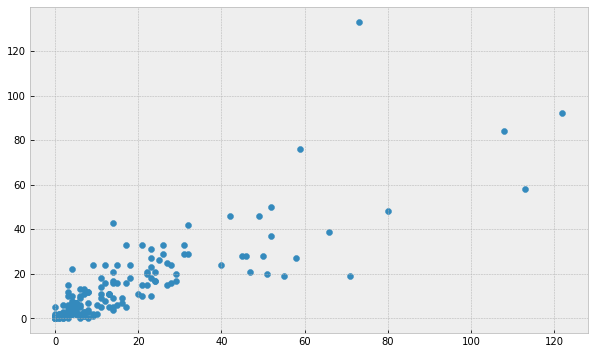

In [213]:
plt.figure(figsize=(10,6))
plt.scatter(X['nt'], X['y'])
plt.show()

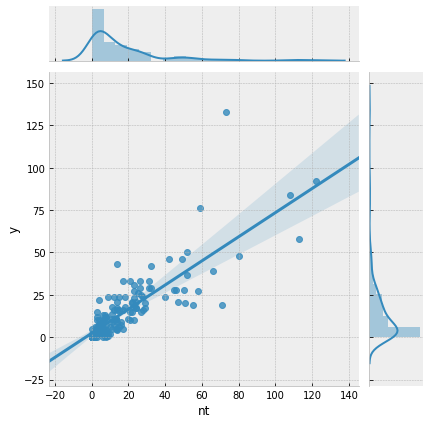

In [214]:
sns.jointplot('nt', 'y', data=X, kind='reg')

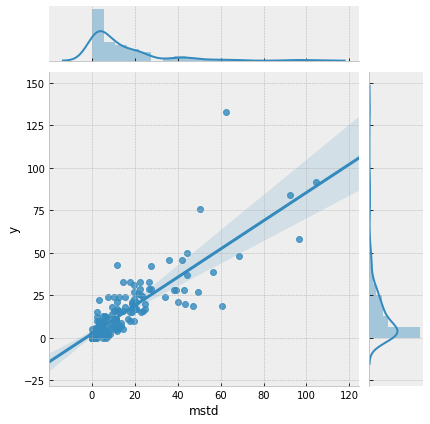

In [215]:
sns.jointplot('mstd', 'y', data=X, kind='reg')

looking at logistic likelihood linear likelohood  

In [106]:
#This is to forcast only one item like the fonction and to take a look at particular issue
start = time.time()
id=11373

dfforc=pd.DataFrame()
now=datetime(2015, 9, 30)
item=dfItems.loc[lambda df1: df1.item_id ==id,:]
idate=item['fdate']
idate=idate.to_numpy(dtype="datetime64[D]")
idatets=(idate - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
idate=datetime.utcfromtimestamp(idatets)
dayout= np.asscalar(item['days_out'].to_numpy())
if dayout>(now-datetime(2013, 4,1)).days-35:
    dayout=(now-datetime(2013, 4,1)).days -35
cat=np.asscalar(item['item_category_id'].to_numpy())
print(cat)
print(item)
print(dayout)
isale= Newsales_by_ID.loc[lambda df1: df1.item_id ==id,:]
isale=isale['item_cnt_day']
sample=Newsales_by_ID.loc[lambda df1: df1.item_category_id ==cat,:]
sample=sample.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sample=sample.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]
sampledb=Newsales_by_ID_db.loc[lambda df1: df1.item_category_id ==cat,:]
sampledb=sampledb.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sampledb=sampledb.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]
sampleym=Newsales_by_ID_ymonth.loc[lambda df1: df1.item_category_id ==cat,:]
sampleym=sampleym.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sampleym=sampleym.loc[lambda df1: idate-df1.fdate>np.timedelta64(1, 'D'),:]
sample2=sample['item_cnt_day']
sampledb=sampledb['date_block_num']   
sampleym=sampleym['month']
#print(sampledb)
#print(sample2)
X=pd.DataFrame()
XF=pd.DataFrame()
if dayout<nday:
    col_list=list(range(0,dayout+1))
else:
    col_list=list(range(dayout-nday,dayout+1))
fcol_list=list(range(dayout+2,dayout+2+nday))
#print(len(sample2.index))
print(fcol_list)
print(col_list)
if dayout<7:
    lweek_list=list(range(0,dayout+1))
else:
    lweek_list=list(range(dayout-7,dayout+1))
    
X['nt']=sample2[col_list].to_numpy().sum(axis=1)

if dayout>31: #use autoregressive model
############# ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA ARIMA #################################
    stst = pd.DataFrame()
    stsy = pd.DataFrame()
    sts=dfSales.loc[lambda df1: df1.item_id	 == id,:]
    sts=sts.groupby(['date_block_num']).agg({"item_cnt_day":"sum"})
    sts=sts.rename(columns={'date_block_num' : 'ds', 'item_cnt_day' : 'y'})
    stst['ds']=sts.index
    stst['ds']=stst['ds'].apply(lambda df1: datetime(2013, 1, 1)+relativedelta(months=+df1))
    stsy=(sts['y'].to_numpy())
    stsy=np.log(stsy)#log for stationarity
    if len(stsy)>4 and stsy.std()>0 and stsy.sum()/dayout>1/30:
        if dayout>400 and len(stsy)>12: #model with sesonality               
            pipeline = Pipeline([
             ('fourier', FourierFeaturizer(k=1, m=12)),
             ("model", pm.AutoARIMA(seasonal=True,d=1 , suppress_warnings=True))])#auto fit sarima
            pipeline2 = Pipeline([
            ("model", pm.ARIMA(order=(1, 0,0), seasonal_order=(1,0, 0, 12), suppress_warnings=True))]) #basic arima p=1 s=12 
        else: #with no sesonality less than 1 year of data                 
            pipeline = Pipeline([
             ("model", pm.AutoARIMA(seasonal=False,d=1 , suppress_warnings=True))])#auto fit arima
            pipeline2 = Pipeline([
            ("model", pm.ARIMA(order=(1, 0,0), suppress_warnings=True))])#basic arima p=1   

        pipeline.fit(stsy)#fit auto
        pred=pipeline.predict(1)#predict 1 with auto
        pred=np.exp(pred)#inverse log

        pipeline2.fit(stsy)#fit basic
        pred2=pipeline2.predict(1)#predict 1 with basic
        pred2=np.exp(pred2)#inverse log

    else:
        pred=[0]
        pred2=[0]

    dfforc['autoARIMA']=max(pred,[0]) 
    dfforc['ARIMA_10012']=max(pred2,[0])
    dfforc['lastmonth']=np.exp(stsy[-1])

if dayout<800 and len(X.index)>=3:
     # X to train XF to forcast                    
        X['LastW']=sample2[lweek_list].to_numpy().sum(axis=1)#sum last 7 day less volatyle than last day
        XF['LastW']=isale[lweek_list].to_numpy().sum(axis=1)
        XF['nt']=isale[col_list].to_numpy().sum(axis=1)
        X['y']=sample2[fcol_list].to_numpy().sum(axis=1)#for all item sum the sales on the same age we try to forcast
        #X['db']=sampledb[fcol_list].to_numpy().max(axis=1)#for all item the date_block_num at that same age to adjust to time trend
        #XF['db']=db
        #m=sampleym[fcol_list].to_numpy().max(axis=1)#m is the month of the coreponding to the age 
        X['mstd']= (((X['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()# mstd is mean std ajusted prediction 
        XF['mstd']= (((XF['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()
        #base on category history and sale history we have for the item we try to 
        #['db']=X['db']*X['mstd'] # db * mstd to adjust forcast to trend
        #XF['db']=XF['db']*XF['mstd']
        X['Last']=sample2[dayout].to_numpy()
        XF['Last']=isale[dayout].to_numpy()
        XF=XF.fillna(0)
        if XF['nt'].empty==True or X['nt'].std() ==0:
             dfforc['reg_lin_mul']=XF['LastW']*4.2
        else:
            
            Y=X['y'] 
            X=X.fillna(0)
            Y=Y.fillna(0)
            print(X)
            
            X1=X.drop(columns=['y','nt'])#drop mstd 'nt'
            X2=X.drop(columns=['y','mstd','nt'])#drop mstd 'nt' dt
            X3=X.drop(columns=['y','Last'])#drop mstd 'nt' 
            X4=X.drop(columns=['y','nt','Last'])#drop mstd 'nt' dt
            #print(X1)          

            X1=X1.to_numpy()
            X2=X2.to_numpy()
            X3=X3.to_numpy()
            X4=X4.to_numpy()
            Ydf=Y          
            Y=Y.to_numpy()
            ###############################################################
            # FIT X Y 
            #params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]}
            #knn = neighbors.KNeighborsRegressor()
           # model = GridSearchCV(knn, params, cv=5)
            #fit the model and make predictions
            #model.fit(X0,Ydf)
       
            reg1 = LinearRegression().fit(X1, Y)#build lin reg model 1
            reg2 = LinearRegression().fit(X2, Y)#build lin reg model 2
            reg3 = LinearRegression().fit(X3, Y)#build lin reg model 3
            reg4 = LinearRegression().fit(X4, Y)#build lin reg model 4
            ##                                                            ##
            ################################################################
            
            ##################################################################
            #prepare XF dataframe to forcast 
            #for i in range(1,13):                             
                #XF['s'+str(i)]=0                                
            #XF.loc[0,'s'+str(month)]=XF.loc[0,'mstd']          
            XF=XF.fillna(0) 
           
            XF1=XF.drop(columns=['nt'])#drop mstd 'nt'
            XF2=XF.drop(columns=['mstd','nt'])#drop mstd 'nt' dt
            XF3=XF.drop(columns=['Last'])#drop mstd 'nt' 
            XF4=XF.drop(columns=['nt','Last'])#drop mstd 'nt' dt
            #print(XF1)
            XF1=XF1.to_numpy()                                   
            XF2=XF2.to_numpy()                                   
            XF3=XF3.to_numpy()
            XF4=XF4.to_numpy()
            ##################################################### 
            
            #################################################################
            # FROC
                     
            forc1 =max([0],reg1.predict(XF1))#forcast 1 
            forc2 =max([0],reg2.predict(XF2))#forcast 2
            forc3 =max([0],reg3.predict(XF3))#forcast 3
            forc4 =max([0],reg4.predict(XF4))#forcast 4
            
            print(forc1)
            print(forc2)
            print(forc3)
            print(forc4)
            if forc1>np.sum([forc2,forc3,forc4])*2: forc1=[np.sum([forc2,forc3,forc4])/3]
            if forc2>np.sum([forc1,forc3,forc4])*2: forc2=[np.sum([forc1,forc3,forc4])/3]
            if forc3>np.sum([forc2,forc1,forc4])*2: forc3=[np.sum([forc2,forc1,forc4])/3]
            if forc4>np.sum([forc2,forc3,forc1])*2: forc4=[np.sum([forc2,forc3,forc1])/3]
            dfforc['reg_lin_mul1']=forc1# add forcast to forcast 1 dataframe
            dfforc['reg_lin_mul2']=forc2# add forcast to forcast 2 dataframe
            dfforc['reg_lin_mul3']=forc3# add forcast to forcast 3 dataframe
            dfforc['reg_lin_mul4']=forc4# add forcast to forcast 4 dataframe
real=itemtoforctest.loc[lambda df1: df1.index ==id,:]
print('real')            
print(real) 
print('forc')
print(dfforc)

C:\Users\Jean-Philippe\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



9
                                  item_name  item_id  item_category_id  \
10974  Доставка до пункта выдачи (Boxberry)    11373                 9   

           fdate  total_cnt  days_out  
10974 2013-01-08     4310.0       995  
877
[879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908]
[847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877]
real
         item_cnt
item_id          
11373      2253.0
forc
    autoARIMA  ARIMA_10012  lastmonth
0  328.631484   158.500154      246.0


In [105]:
start = time.time()
id=11373
nday=30
db=33
month=10 
now=datetime(2015, 9, 30)
item=dfItems.loc[lambda df1: df1.item_id ==id,:]
dayout= np.asscalar(item['days_out'].to_numpy())
cat=np.asscalar(item['item_category_id'].to_numpy())
if dayout>(now-datetime(2013, 4,1)).days-33:
    dayout=(now-datetime(2013, 4,1)).days -33

isale= Newsales_by_ID.loc[lambda df1: df1.item_id ==id,:]
isale=isale['item_cnt_day']
sample=Newsales_by_ID.loc[lambda df1: df1.item_category_id ==cat,:]
sample=sample.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sampledb=Newsales_by_ID_db.loc[lambda df1: df1.item_category_id ==cat,:]
sampledb=sampledb.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sampleym=Newsales_by_ID_ymonth.loc[lambda df1: df1.item_category_id ==cat,:]
sampleym=sampleym.loc[lambda df1: now-df1.fdate>np.timedelta64(nday, 'D')]
sample2=sample['item_cnt_day']
sampledb=sampledb['date_block_num']   
sampleym=sampleym['month']
X=pd.DataFrame()
XF=pd.DataFrame()
if dayout<nday:
    col_list=list(range(0,dayout+1))
else:
    col_list=list(range(dayout-nday,dayout+1))
print(dayout)
print(col_list)

fcol_list=list(range(dayout+2,dayout+2+nday))
print(fcol_list)
X['nt']=sample2[col_list].to_numpy().sum(axis=1)#for all item sum the sales on the same age
XF['nt']=isale[col_list].to_numpy().sum(axis=1)
print(XF['nt'])
X['y']=sample2[fcol_list].to_numpy().sum(axis=1)#for all item sum the sales on the same age we try to forcast
X['db']=sampledb[fcol_list].to_numpy().max(axis=1)#for all item the date_block_num at that same age to adjust to time trend
XF['db']=db
m=sampleym[fcol_list].to_numpy().max(axis=1)#m is the month of the coreponding to the age 
X['mstd']= (((X['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()# mstd is mean std ajusted prediction 
XF['mstd']= (((XF['nt']-X['nt'].mean())/X['nt'].std())*X['y'].std())+X['y'].mean()
#base on category history and sale history we have for the item we try to 
X['db']=X['db']*X['mstd'] # db * mstd to adjust forcast to trend
XF['db']=XF['db']*XF['mstd']
X['Last']=sample2[dayout].to_numpy()
XF['Last']=isale[dayout].to_numpy()
XF=XF.fillna(0)
if XF['nt'].empty==True:
    print(0) 
else:
    #we create 12 variable for every month of the year and put mstd in its coresponfing month to catch the seasonality                                           
    for i in range(1,13):
        X['s'+str(i)]=0                                          
    j=0  
    for i in m: 
        if i==0:
            i=1
        X.loc[j,'s'+str(i)]=X.loc[j,'mstd']
        j=j+1
    Y=X['y']    
    X=X.drop(columns=['y','nt','mstd'])
    X=X.fillna(0)
    Y=Y.fillna(0)
    print(X)
    X=X.to_numpy()
    Y=Y.to_numpy()
    reg = LinearRegression().fit(X, Y)
    print(month)
    print(XF)
   
    for i in range(1,13):
        XF['s'+str(i)]=0
    XF.loc[0,'s'+str(month)]=XF.loc[0,'mstd']
    XF=XF.fillna(0)
    XF=XF.drop(columns=['nt','mstd'])
    XF=XF.to_numpy()
    forc=reg.predict(XF)
    print(forc)
    real=itemtoforctest.loc[lambda df1: df1.index ==id,:]
    print(real)
    end = time.time()  
    print("Elapsed (after compilation) = %s" % (end - start))

    print(forc)

879
[849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879]
[881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910]
Series([], Name: nt, dtype: int64)
0
